In [1]:
import numpy as np
import pandas as pd
import random


#Sklearn functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split,StratifiedKFold,RepeatedKFold


from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

from imblearn.over_sampling import SVMSMOTE
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova
from skbio.diversity import beta_diversity

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Actions:
1. Read Metaphlan table and Metadata.
2. Filter out based on prevalence and taxonomic level
3. Split data (folds)
4. Test prediction model


Some other interesting approaches:
1. Try Over/Under- sampling using SMOTE https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/


In [2]:
def Creat_taxa_table(df):
    new_columns = []
    new_names = []
    non_zero_proportions = []
    Levels = []
    for column in df.columns:
        # Extract the name after the last '.' in the column header
        last_dot_index = column.rfind('.')
        new_column_name = column[last_dot_index + 1:]
        new_columns.append(column)
        new_names.append(new_column_name)

        # Calculate the proportion of non-zero values in the column
        non_zero_count = df[column].astype(bool).sum()
        total_count = df[column].count()
        non_zero_proportion = non_zero_count / total_count
        non_zero_proportions.append(non_zero_proportion)

        #Get info about taxonomy level
        level = new_column_name.split("__")[0]
        Levels.append(level)
    new_df = pd.DataFrame({
        'Taxonomy': new_columns,
        'Short_taxonomy': new_names,
        'Prevalence': non_zero_proportions,
        'Taxonomy_level' : Levels
    })

    return new_df
    
def Shorten_names(df, Info):
    short_names = Info['Short_taxonomy'].tolist()
    new_column_names = dict(zip(df.drop(columns=["NEXT_ID"]).columns, short_names))
    new_column_names["NEXT_ID"] = "NEXT_ID"
    df = df.rename(columns=new_column_names)
    return(df)
def Match_id_type(Denominators, DF): 
    DF_change = DF[["NEXT_ID", "NG_ID"]]
    Denominators = pd.merge(DF_change, Denominators, on='NG_ID')

    Denominators = Denominators.drop('NG_ID', axis=1)
    DF = DF.drop('NG_ID', axis=1)
    
    return(Denominators, DF)


In [3]:
def Read_data(Taxonomy_table = "Data/Taxonomy_for_prediction.tsv", Metadata_matrix="Data/Metadata_for_analysis_cross.tsv",Table_GeomMean="Data/Table_GeomMean.tsv"):
    DF = pd.read_csv(Taxonomy_table, delimiter="\t")
    Meta = pd.read_csv( Metadata_matrix, delimiter="\t")
    Denominators = pd.read_csv(Table_GeomMean, delimiter="\t")
    Denominators, DF = Match_id_type(Denominators, DF)
    #Remove unclassified.
    DF = DF.drop(columns=['UNCLASSIFIED'])
    #Get table with: 1. Taxa, 2. Short name, 3. Prevalence
    Info_taxonomy = Creat_taxa_table(DF.drop(columns=["NEXT_ID"]) )
    #Use short names
    DF = Shorten_names(DF, Info_taxonomy)
    
    return(DF, Info_taxonomy, Meta, Denominators)

In [4]:
DF, Info_taxonomy, Meta, Denominators = Read_data()

We will create a function that accepts:
1.  Metaphlan taxonomy | taxonomic level | Prevalence threshold  and filters to have the prediciton table
2.  A Phenotype to predict
3. Fold strategy

In [5]:
def Prepare_features_X(df, Level="all", Prev_threshold=0, info = Info_taxonomy, Transform="clr", Den=Denominators, Pseudocount=1.575357e-5):
    #filter prevalence
    info = info[info["Prevalence"] >= Prev_threshold]
    if Level != "all":
        info = info[info["Taxonomy_level"] == Level]
    ID = df["NEXT_ID"]
    df = df.drop(columns=["NEXT_ID"])    
    if Transform == "clr":
        #CLR transform the data
        Den = Den[Den['NEXT_ID'].isin(ID.tolist()) ]    
        df = CLR_transform(df, denominators=Den, epsilon=Pseudocount )
    elif Transform == "arcsin":
        df = df.apply(ast_transform, axis=1)
    elif Transform == None:
        next
    #Filter
    df_filter = df[ info["Short_taxonomy"] ]
    df_filter.insert(0, "NEXT_ID", ID)
    return(df_filter)
def CLR_transform(df, denominators = None,epsilon=1.575357e-5):
    #1e-6
    #ID = df["NEXT_ID"]
    #df = df.drop(columns=["NEXT_ID"])
    #Add a small constant value to avoid division by zero
    df = df + epsilon
    
    if isinstance(denominators, pd.DataFrame):
        geometric_means = denominators["Denominator"]
    else:    
        # Compute the geometric mean of each row
        geometric_means = np.exp(np.log(df).mean(axis=1))
    # Divide each row by its geometric mean
    clr_df = df.div(geometric_means, axis=0)

    # Take the natural logarithm of the CLR transformed values
    clr_df = np.log(clr_df)

    #clr_df.insert(0, "NEXT_ID", ID)
    return(clr_df)
def ast_transform(x):
    x = x/x.sum()
    return(np.arcsin(np.sqrt(x))*2)
def Match_x_y(df, metadata, feature_name="infant_health_food_allergy"):
    metadata = metadata[["NEXT_ID", feature_name] ]
    merged_df = df.merge(metadata, on="NEXT_ID", how="left")
    merged_df = merged_df.dropna()
    return(merged_df)
def Make_pcoa(Input_ml, metric = "sqeuclidean", Phenotype="infant_health_food_allergy", Check_eigen=False):
    #Make a PCoA
    if metric == "bray" or metric == "braycurtis":    
        distance = beta_diversity(metric = 'braycurtis', counts = Input_ml.drop(columns = [Phenotype, "NEXT_ID"]  ) , ids= Input_ml.index)
    if metric == "euclidean" or metric == "eu" or metric == 'sqeuclidean':
        distance = beta_diversity(metric = 'sqeuclidean', counts = Input_ml.drop(columns = [Phenotype, "NEXT_ID"]  ) , ids= Input_ml.index)
    #1. Fit PCoA
    pcoa_results = pcoa(distance)
    #2. Get PCs
    pcoa_coords = pcoa_results.samples.values
    variance_explained = pcoa_results.proportion_explained
    if Check_eigen == True:
        eigenvalues = pcoa_results.eigvals
        plt.figure(figsize=(8, 6))
        plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, color='b', alpha=0.7)
        plt.xlabel('Principal Component')
        plt.ylabel('Eigenvalue')
        plt.title('Scree Plot')
        plt.grid()
        plt.show()
    
    #3. Colors
    groups = Input_ml[Phenotype].unique()
    print(groups)
    colors = ['red', 'blue']
    plt.figure(figsize=(8, 6))
    for i, group in enumerate(groups):
        group_mask = (Input_ml[Phenotype] == group)
        plt.scatter(pcoa_coords[group_mask, 0], pcoa_coords[group_mask, 1], label=group, color=colors[i])

    # Add axis labels and a legend
    plt.xlabel(f'PC1 ({variance_explained[0]*100:.2f}%)')
    plt.ylabel(f'PC2 ({variance_explained[1]*100:.2f}%)')
    plt.legend(title='Group')
    plt.title('PCoA Plot with Colored Groups')
    plt.grid()
    plt.show()
    
    

In [6]:
def Run_basic_model(X,y, N_repeats_cv = 1, random_state=7644, CV=10, Model="rf", Oversampling=False, Save_shap="shap_tables/shap.csv"):
    np.random.seed(random_state)
    random.seed(random_state)
    steps = []
    
    #print("Running: " + y)
    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
    value_counts_df = Y.value_counts()
    print(value_counts_df)
    
    if Oversampling == True:
        oversample = SVMSMOTE()
        steps.append(("over", oversample))        
    
    # Create the Random Forest classifier
    if Model == "rf":
        classifier = RandomForestClassifier(n_estimators=500, random_state=random_state) #100 trees
    elif Model == "xgb":
        if Oversampling == False:
            W = value_counts_df[0]/value_counts_df[1]
        else: W = 1
        classifier = xgb.XGBClassifier(random_state=random_state, scale_pos_weight=W)
        #classifier = xgb.XGBClassifier( colsample_bylevel=0.075, max_depth=6, learning_rate=0.0025, n_estimators=4000,subsample=0.6, min_child_weight=20. )
    elif Model == "Lasso":
        alpha_values = [0.005,0.01, 0.1, 1.0]  # You can adjust these values based on your data
        param_grid = {'C': alpha_values}
        lasso = LogisticRegression(penalty='l1',solver='liblinear', class_weight="balanced", random_state=random_state)
        grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='roc_auc')
        grid_search.fit(X, Y)
        classifier = grid_search.best_estimator_
        print("Best Alpha:", grid_search.best_params_['C'])

        
    steps.append(('classifier', classifier))
    pipeline = Pipeline( steps )

    # Create cross-validation strategy
    cv = RepeatedStratifiedKFold(n_splits=CV, n_repeats=N_repeats_cv, random_state=random_state)

    # Run the cross-validation and get the accuracy scores
    scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='roc_auc' )

    # Print the average accuracy and standard deviation
    print("Average AUC:", scores.mean())
    print("Standard Deviation:", scores.std())

    AUC_df = {
    "Feature": [y],
    "AUC_mean": [scores.mean()],
    "AUC_std": [scores.std()]
    }

    # Create the DataFrame
    AUC_df = pd.DataFrame(AUC_df)
    
    #Get shap values
    if Model == "xgb":
        Shap = Get_shap(X,Y,classifier)
        Shap["Phenotype"] = y
        Shap.to_csv(Save_shap)
        return(Shap, AUC_df)
    return(AUC_df )
def Check_Permanova(Input_ml, Phenotype): 
    Distance = beta_diversity(metric = 'sqeuclidean', counts = Input_ml.drop(columns = [Phenotype, "NEXT_ID"]  ) , ids= Input_ml.index)
    Result = permanova(Distance, Input_ml, column=Phenotype, permutations=999)
    P = Result["p-value"]
    print("Permanova of {P} has a P-value (999 perm) of {R}".format(P=Phenotype, R=str(P)) )
def Get_shap(X,Y,classifier):
    #Classifier fit in whole dataset
    classifier.fit(X, Y)
    #Explainer of the predicitons
    explainer = shap.TreeExplainer(classifier)
    #Get shap values from ALL samples
    shap_values_all = explainer.shap_values(X)
    #Plot: all samples and plot average importance
    shap.summary_plot(shap_values_all, X)
    shap.summary_plot(shap_values_all, plot_type='bar', feature_names=X.columns )

    ##Create DF
    Mean_shap_values =  np.abs(shap_values_all).mean(0)

    Feature_importance_df = pd.DataFrame(data=Mean_shap_values, columns=["Feature_importance"])
    Feature_importance_df.index = X.columns

    Feature_importance_df= Feature_importance_df.sort_values(by='Feature_importance', ascending=False)
    return(Feature_importance_df)


In [11]:
DF2 = Prepare_features_X(DF, Level="t", Prev_threshold=0.2, Transform="arcsin" )
DF2_clr = Prepare_features_X(DF, Level="t", Prev_threshold=0.2, Transform="clr" )
DF2_none = Prepare_features_X(DF, Level="t", Prev_threshold=0.2, Transform=None )

In [72]:
def Fit_model( DF2, Meta,  Fit = ["XGBoost"], Iterate = ["birth_delivery_mode_simple", "birth_deliverybirthcard_place_delivery_simple", "infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed", "infant_health_eczema_diagnosis_strict", "infant_health_breathing_difficulties", "infant_health_airway_nose_ear_throat_infection_freq"], Shap_file="shap_tables/shap.csv" ):
    phenotype_mapping = {'yes': 1, 'no': 0, "post_labor_CS":1, "VG":0, "home":0, "hospital":1, "0_never":0, "1_once_twice":1, "2_three_to_five":1,"3_six_times_more":1 }
    combined_shap = pd.DataFrame()
    DF_AUC = pd.DataFrame()
    #Test naive classifiers (without much hyperparameter optimization, for that, check below)
    for Phenotype in Iterate:
        print("===={P}=====".format(P=Phenotype))
        Input_ml = Match_x_y(DF2, Meta, Phenotype)
        Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
        Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1])]
        if "Plot" in Fit:
            Make_pcoa(Input_ml, "sqeuclidean", Phenotype, Check_eigen=True )
        if "Lasso" in Fit:
            print("===Lasso===")
            AUCs = Run_basic_model(Input_ml, Phenotype, CV=5, Oversampling=False, Model="Lasso")
            df_auc = AUCs.assign(algorithm="lasso")
            DF_AUC = pd.concat([DF_AUC, df_auc], axis=0)
        if "XGBoost" in Fit:
            print("===XGboost===")
            Shap, AUCs = Run_basic_model(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=False, N_repeats_cv=5, Save_shap=Shap_file )
            combined_shap = pd.concat([combined_shap, Shap], axis=0)
            df_auc = AUCs.assign(algorithm="xgb")
            DF_AUC = pd.concat([DF_AUC, df_auc], axis=0)
        if "RF" in Fit:
            print("===RF===")
            AUCs = Run_basic_model(Input_ml, Phenotype, CV=5, Model="rf", Oversampling=False, N_repeats_cv=5 )
            df_auc = AUCs.assign(algorithm="RF")
            DF_AUC = pd.concat([DF_AUC, df_auc], axis=0)
        if "Permanova" in Fit:
            print("===Permanova===")
            Check_Permanova(Input_ml, Phenotype)
    return(combined_shap, DF_AUC)

====birth_delivery_mode_simple=====
===XGboost===
0.0    368
1.0     46
Name: birth_delivery_mode_simple, dtype: int64
Average AUC: 0.7589992183964788
Standard Deviation: 0.06958984995422914


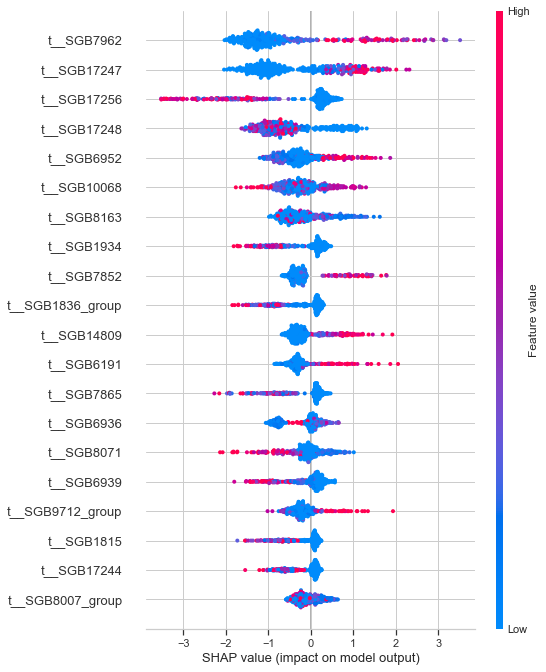

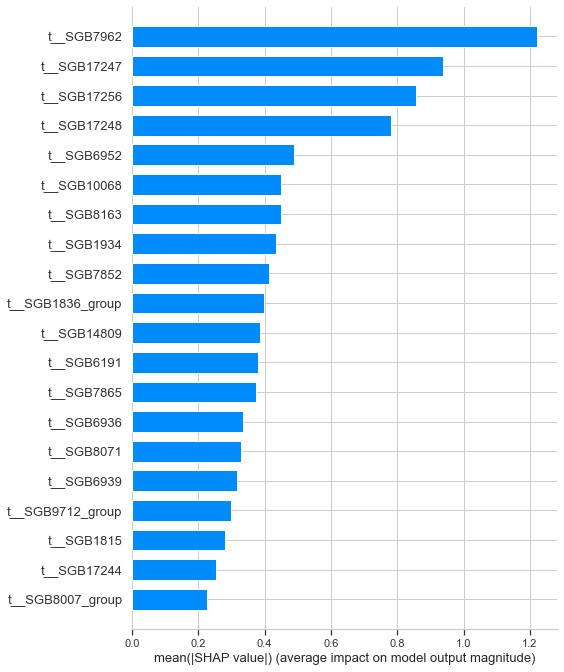

====birth_deliverybirthcard_place_delivery_simple=====
===XGboost===
1    333
0    107
Name: birth_deliverybirthcard_place_delivery_simple, dtype: int64
Average AUC: 0.6278792577842782
Standard Deviation: 0.07246125565105437


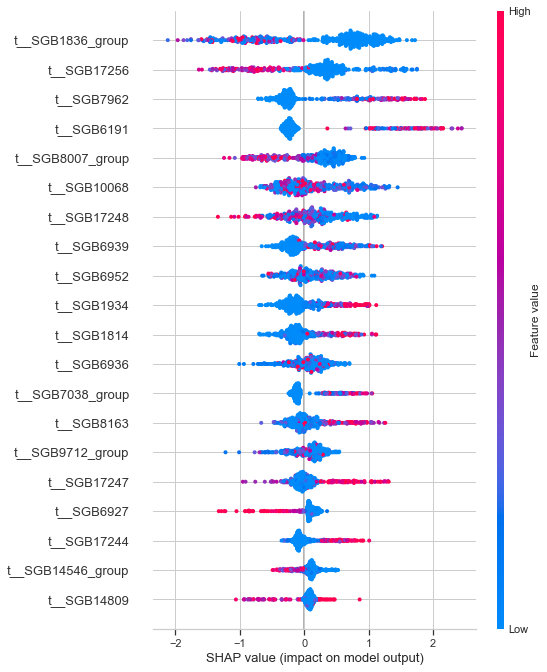

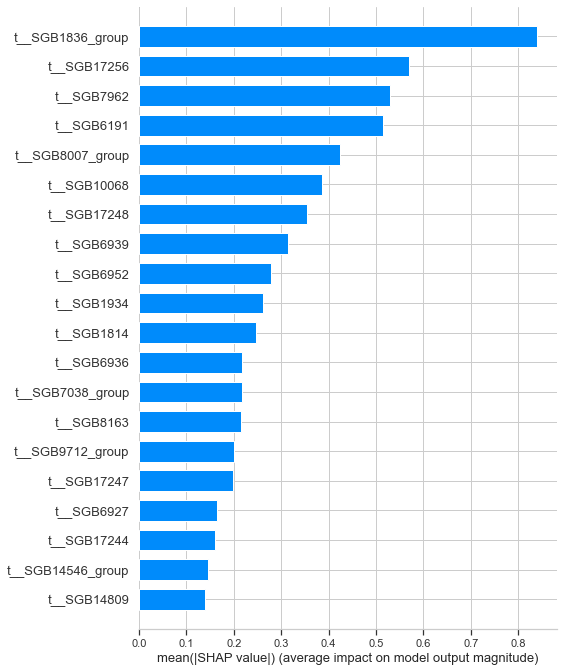

====infant_health_food_allergy=====
===XGboost===
0    332
1     39
Name: infant_health_food_allergy, dtype: int64
Average AUC: 0.6131139755766621
Standard Deviation: 0.09400352109682748


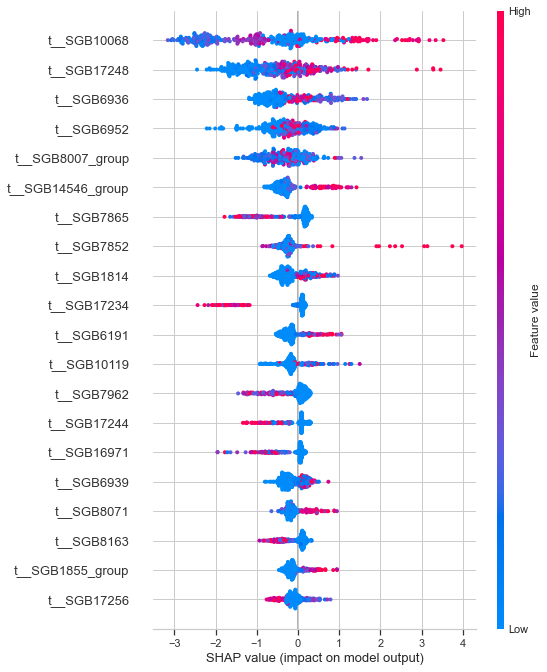

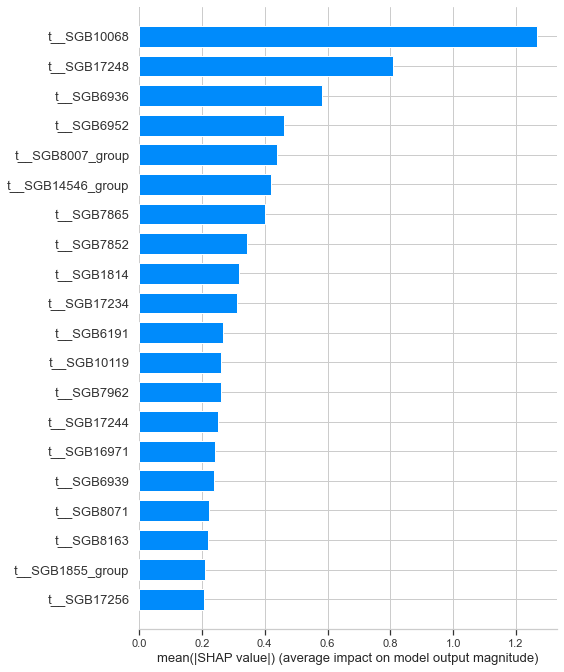

====infant_health_eczema_diagnosis_relaxed=====
===XGboost===
0    275
1     87
Name: infant_health_eczema_diagnosis_relaxed, dtype: int64
Average AUC: 0.47897088532382653
Standard Deviation: 0.04852726966455224


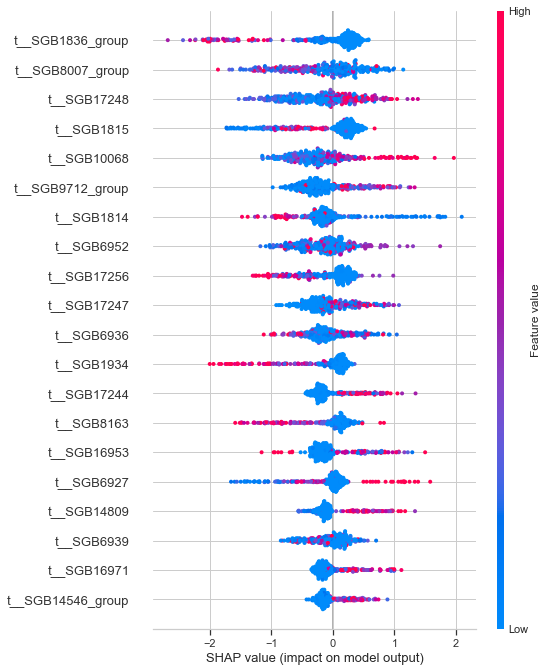

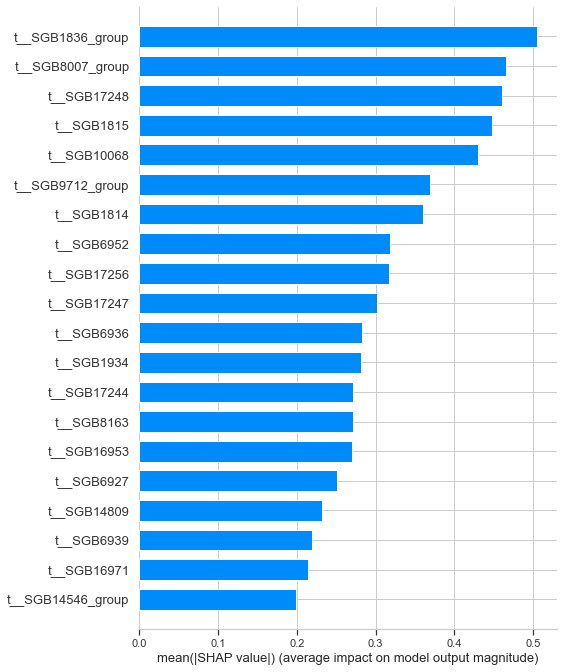

====infant_health_eczema_diagnosis_strict=====
===XGboost===
1    87
0    50
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.5304313725490196
Standard Deviation: 0.07068229753209958


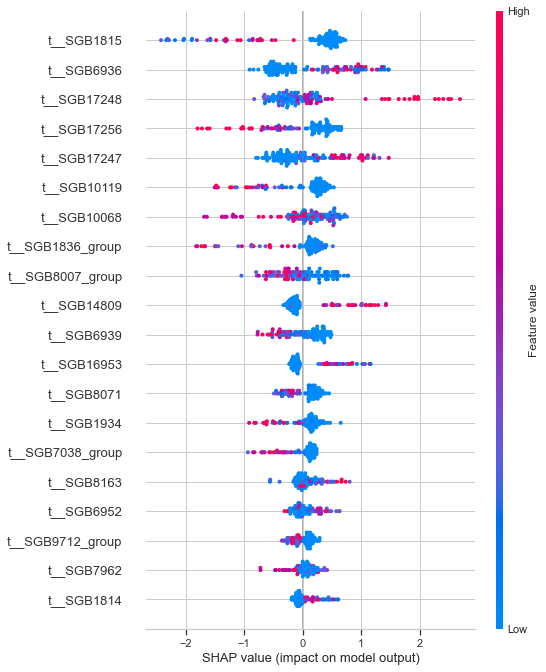

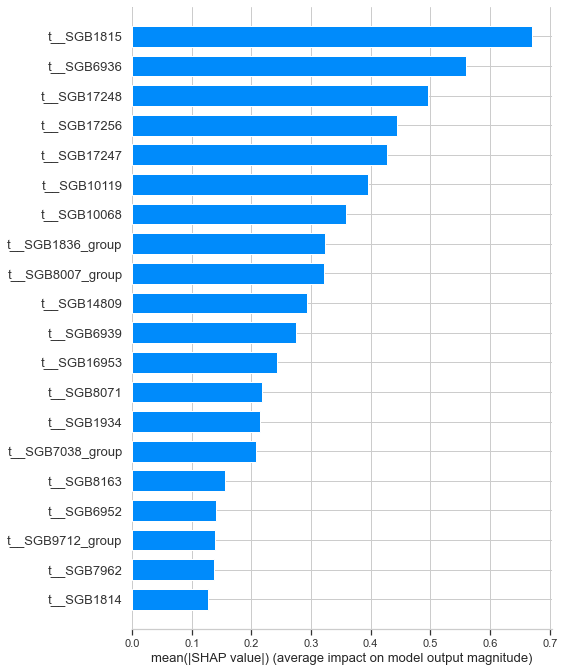

====infant_health_breathing_difficulties=====
===XGboost===
0    259
1     90
Name: infant_health_breathing_difficulties, dtype: int64
Average AUC: 0.4712669683257918
Standard Deviation: 0.06659185474327581


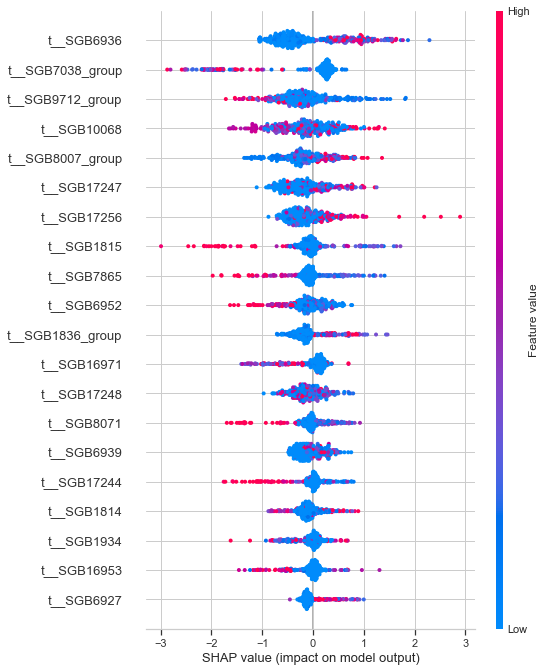

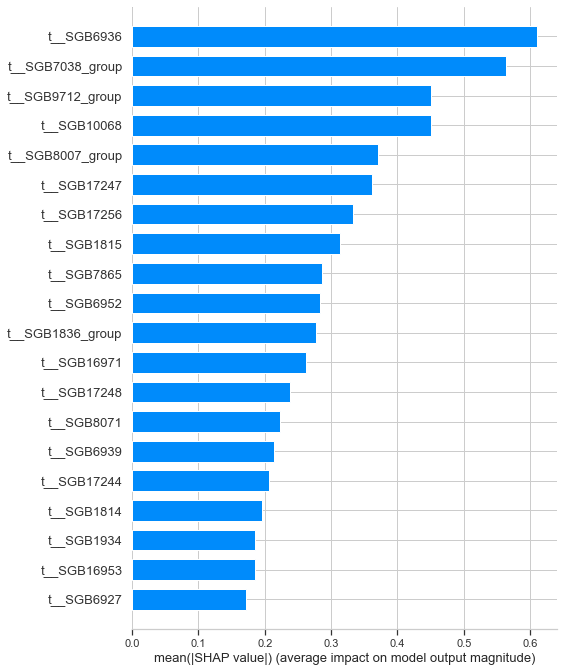

====infant_health_airway_nose_ear_throat_infection_freq=====
===XGboost===
0    110
1     57
Name: infant_health_airway_nose_ear_throat_infection_freq, dtype: int64
Average AUC: 0.614077134986226
Standard Deviation: 0.11669099729706997


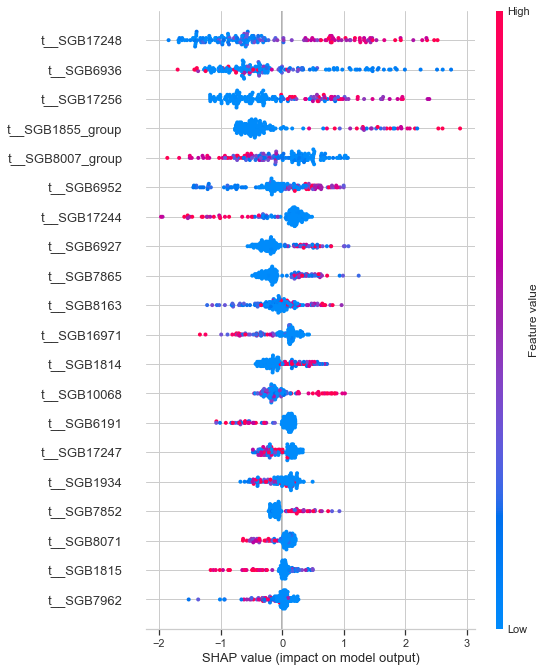

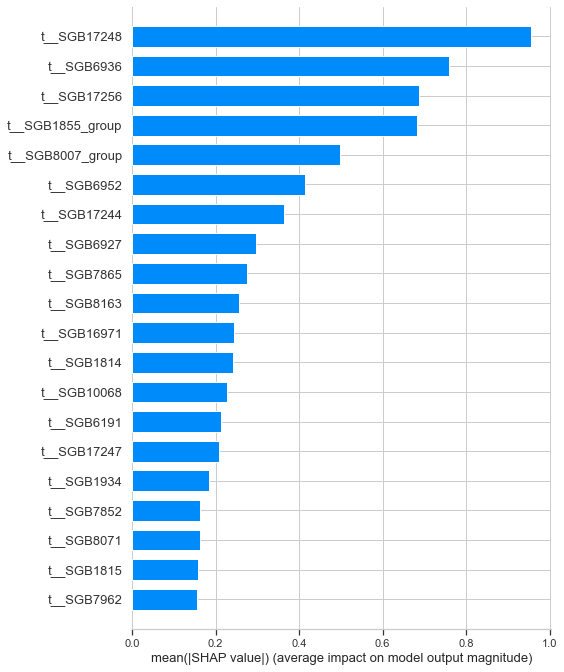

====birth_delivery_mode_simple=====
===XGboost===
0.0    368
1.0     46
Name: birth_delivery_mode_simple, dtype: int64
Average AUC: 0.7505885063145338
Standard Deviation: 0.06722006528880156


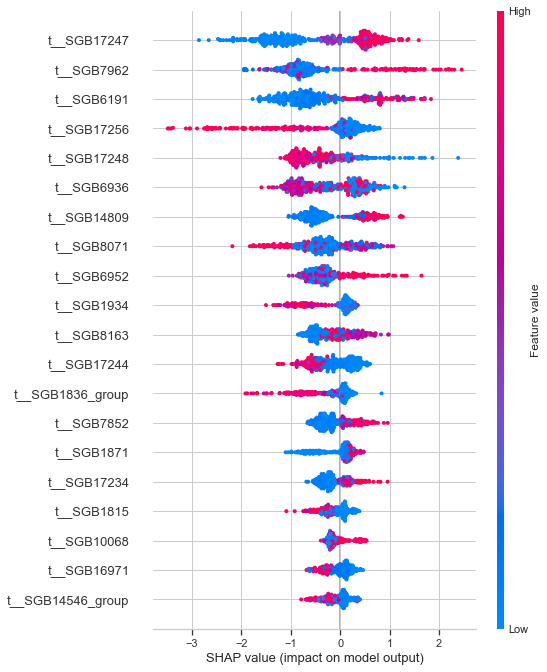

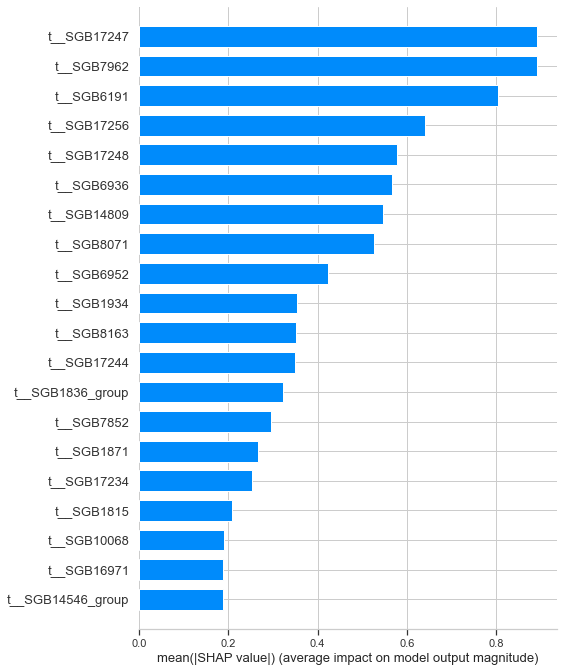

====birth_deliverybirthcard_place_delivery_simple=====
===XGboost===
1    333
0    107
Name: birth_deliverybirthcard_place_delivery_simple, dtype: int64
Average AUC: 0.617841547868685
Standard Deviation: 0.06440576101665962


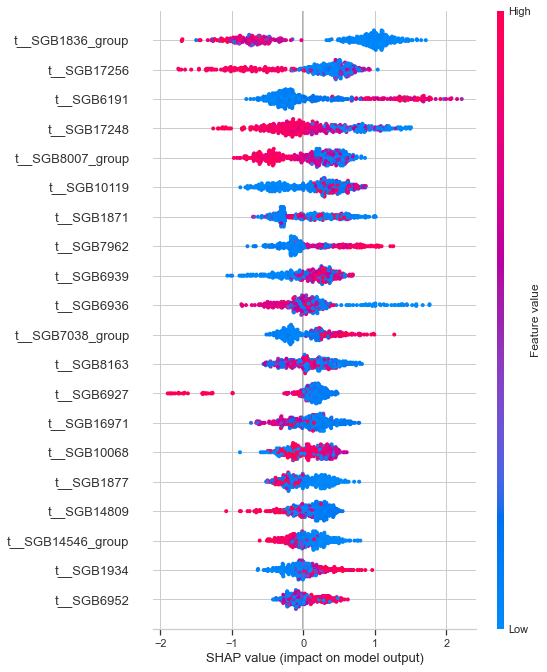

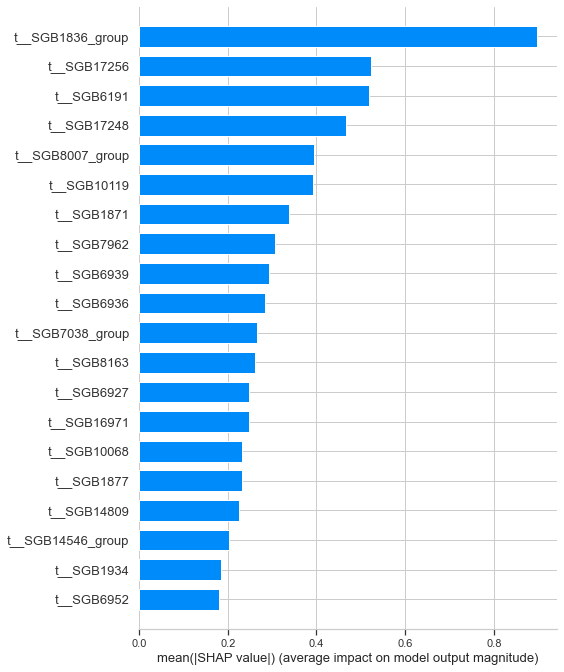

====infant_health_food_allergy=====
===XGboost===
0    332
1     39
Name: infant_health_food_allergy, dtype: int64
Average AUC: 0.5871693480648704
Standard Deviation: 0.09813978807602165


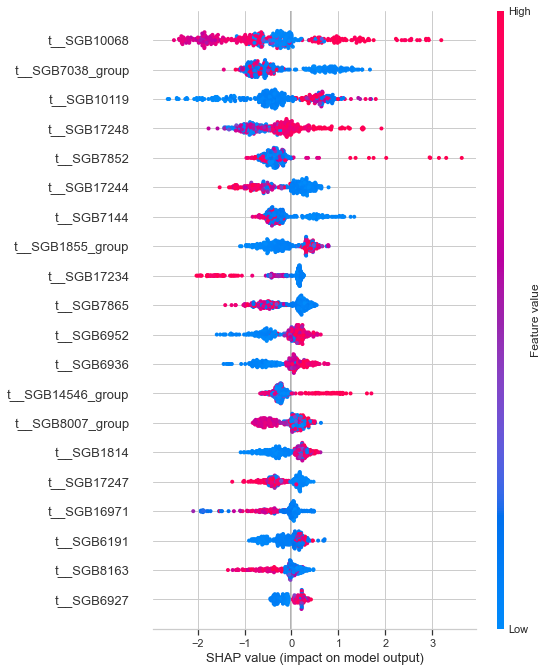

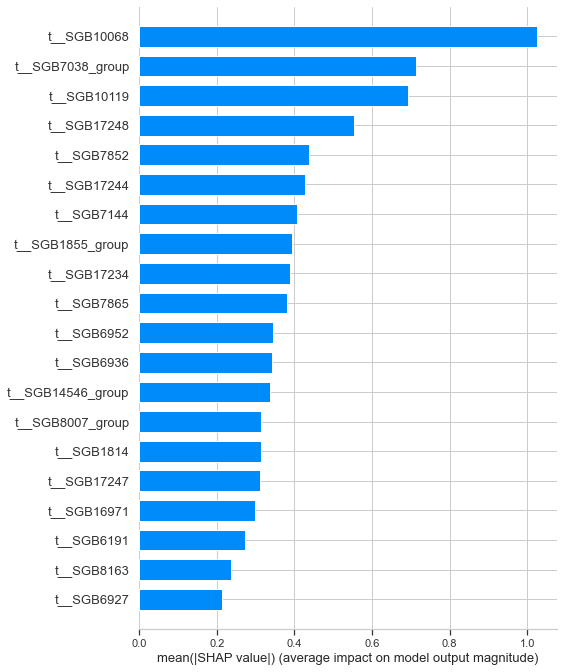

====infant_health_eczema_diagnosis_relaxed=====
===XGboost===
0    275
1     87
Name: infant_health_eczema_diagnosis_relaxed, dtype: int64
Average AUC: 0.4631229946524064
Standard Deviation: 0.04729989770298281


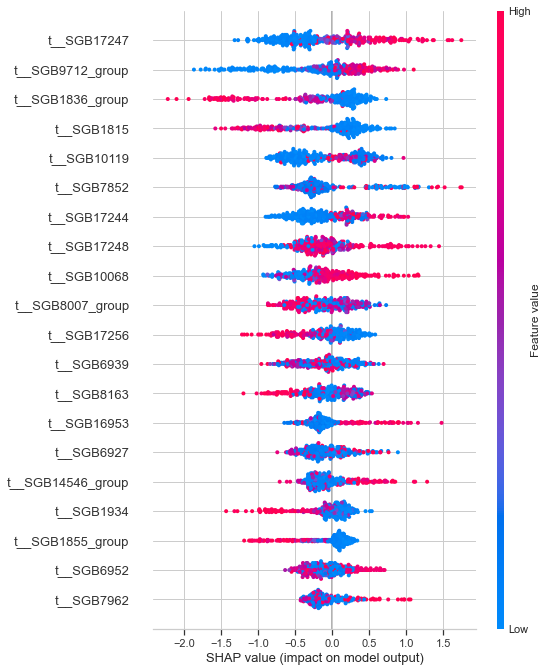

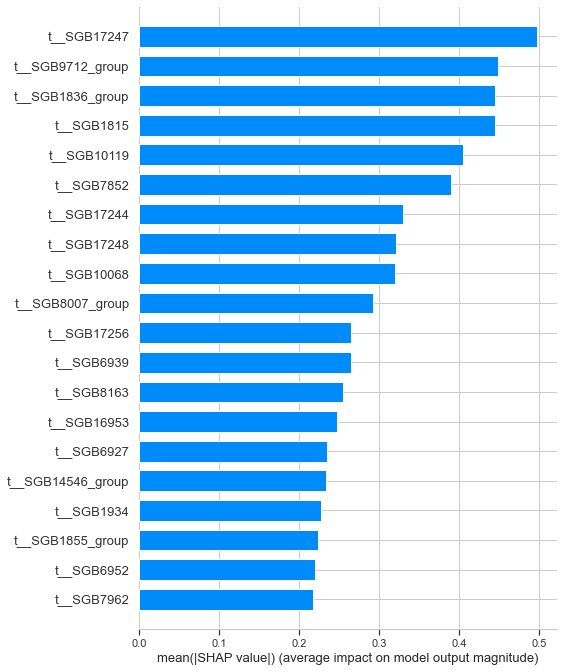

====infant_health_eczema_diagnosis_strict=====
===XGboost===
1    87
0    50
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.5139738562091503
Standard Deviation: 0.08197075337314406


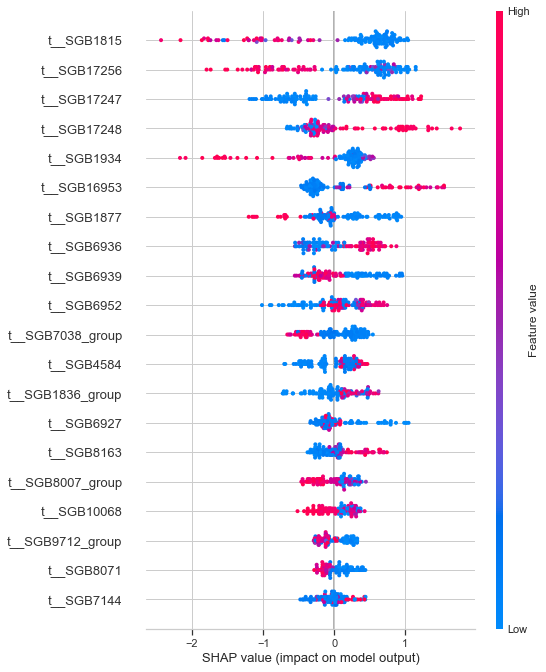

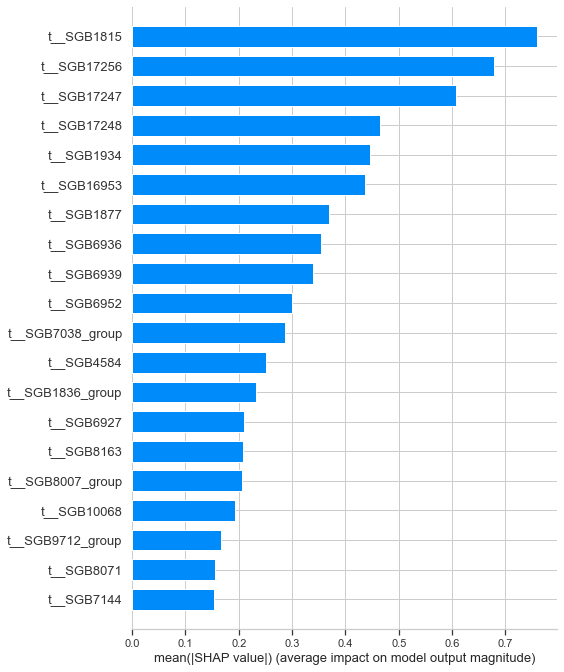

====infant_health_breathing_difficulties=====
===XGboost===
0    259
1     90
Name: infant_health_breathing_difficulties, dtype: int64
Average AUC: 0.49328138092843976
Standard Deviation: 0.05904035270232102


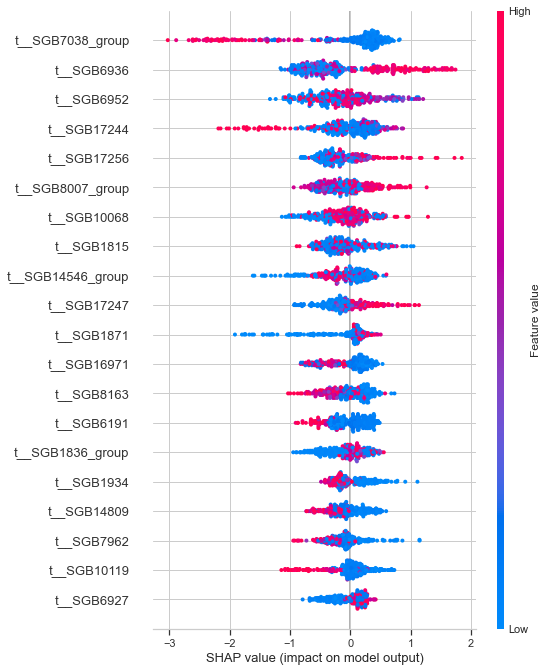

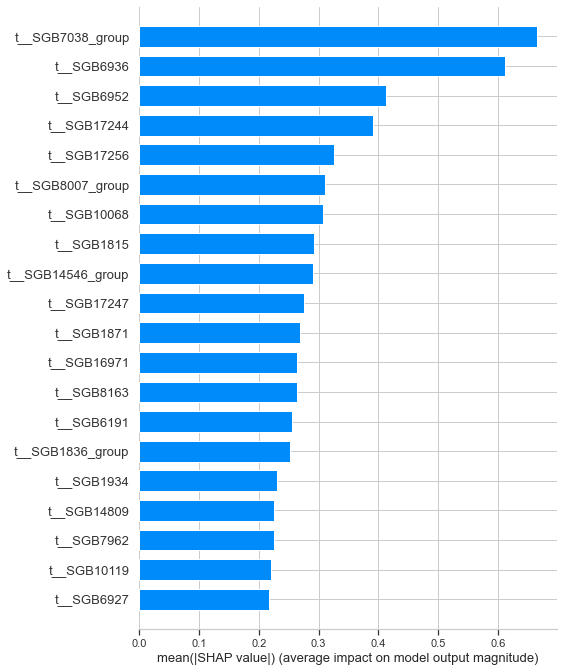

====infant_health_airway_nose_ear_throat_infection_freq=====
===XGboost===
0    110
1     57
Name: infant_health_airway_nose_ear_throat_infection_freq, dtype: int64
Average AUC: 0.5877134986225895
Standard Deviation: 0.1128995026012958


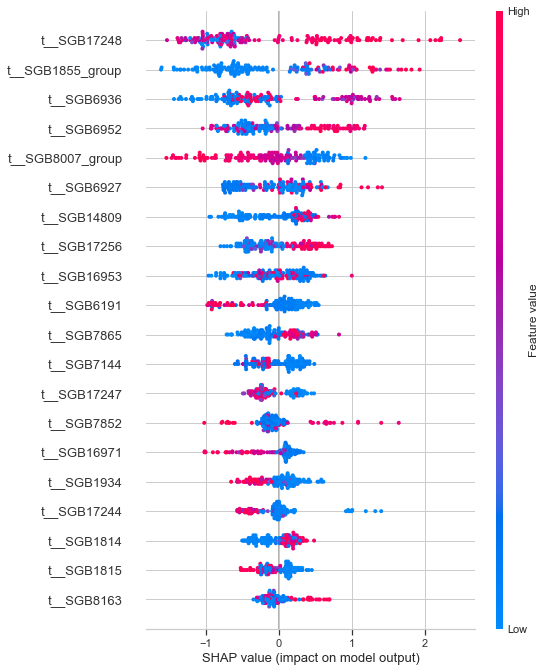

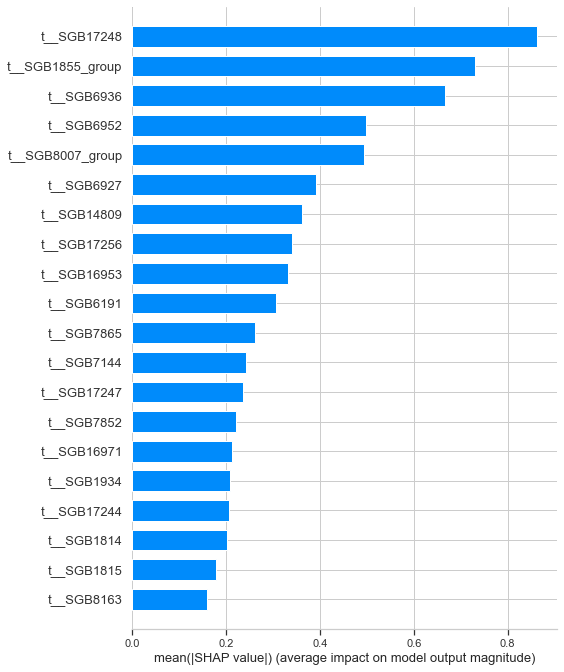

====birth_delivery_mode_simple=====
===XGboost===
0.0    368
1.0     46
Name: birth_delivery_mode_simple, dtype: int64
Average AUC: 0.7484194331317618
Standard Deviation: 0.07720159700371056


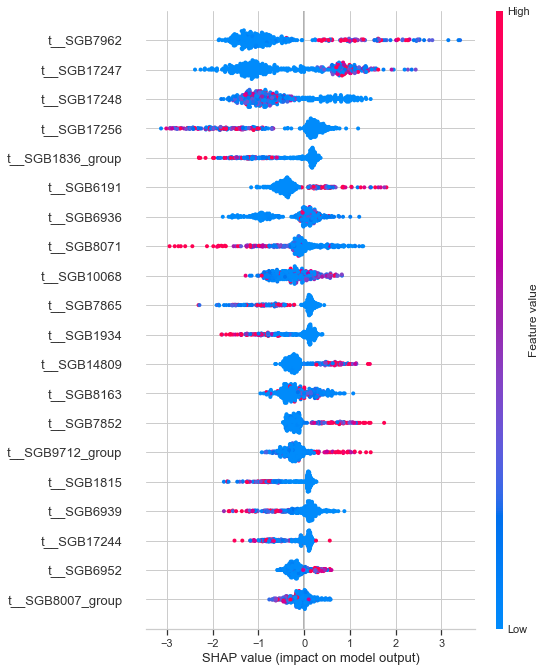

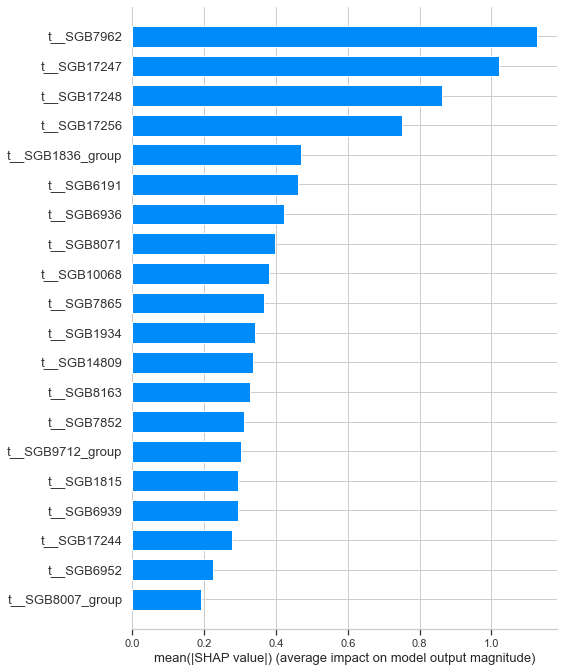

====birth_deliverybirthcard_place_delivery_simple=====
===XGboost===
1    333
0    107
Name: birth_deliverybirthcard_place_delivery_simple, dtype: int64
Average AUC: 0.6190880309197813
Standard Deviation: 0.07692596035163528


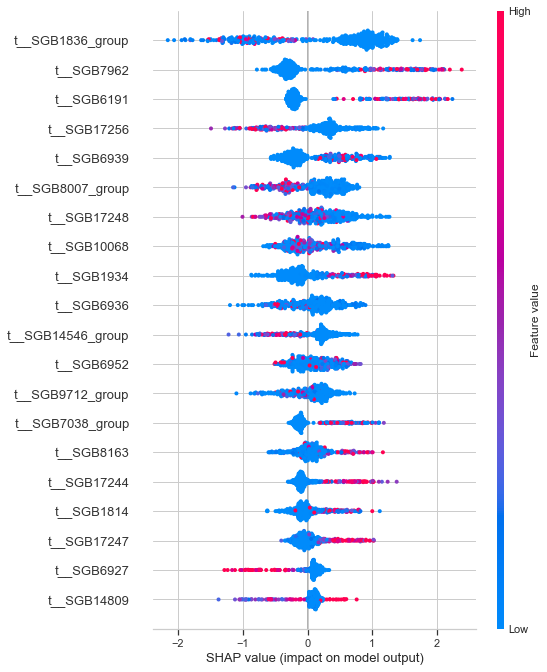

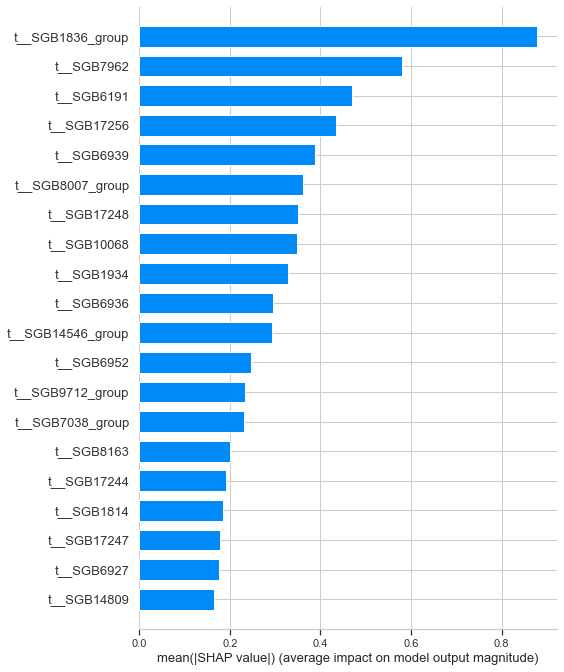

====infant_health_food_allergy=====
===XGboost===
0    332
1     39
Name: infant_health_food_allergy, dtype: int64
Average AUC: 0.5895058796924468
Standard Deviation: 0.09403912396115416


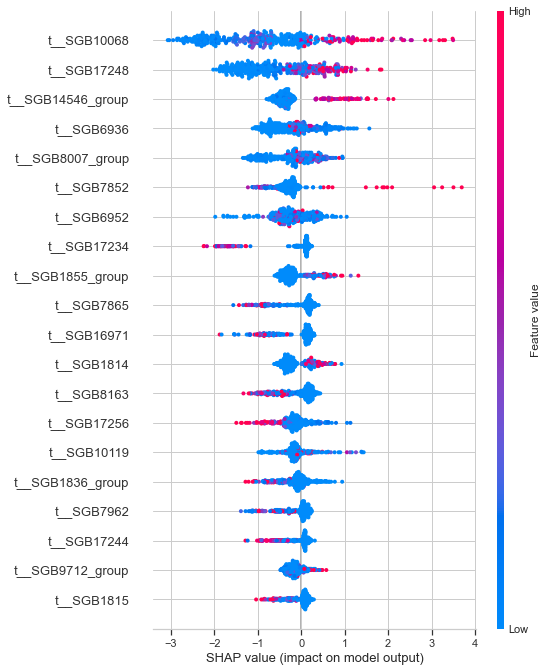

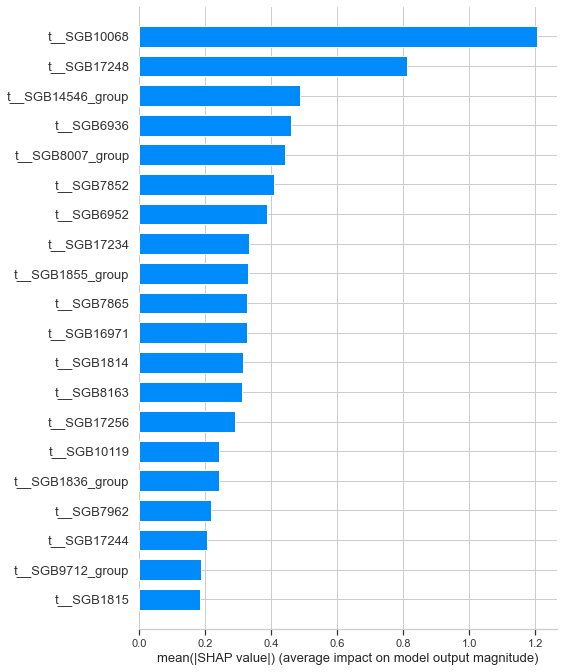

====infant_health_eczema_diagnosis_relaxed=====
===XGboost===
0    275
1     87
Name: infant_health_eczema_diagnosis_relaxed, dtype: int64
Average AUC: 0.5121402257872847
Standard Deviation: 0.056593238430890945


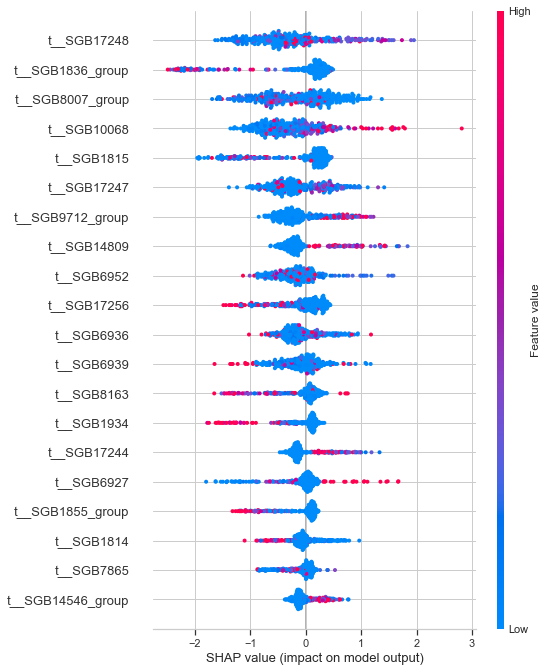

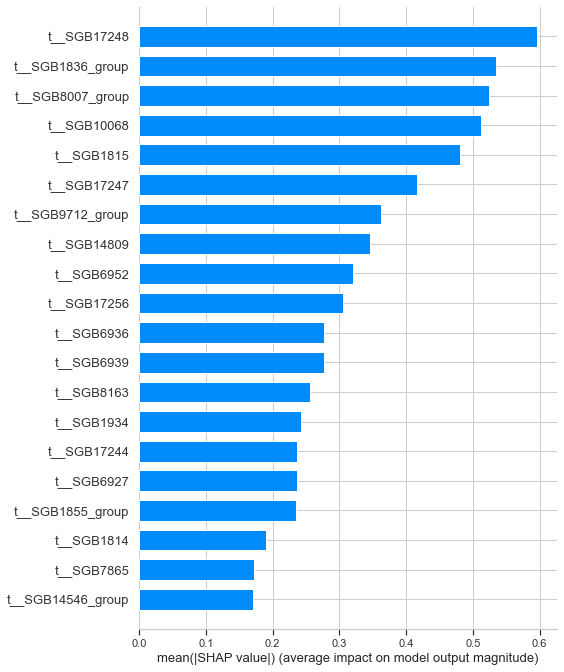

====infant_health_eczema_diagnosis_strict=====
===XGboost===
1    87
0    50
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.5441699346405229
Standard Deviation: 0.08900961044895525


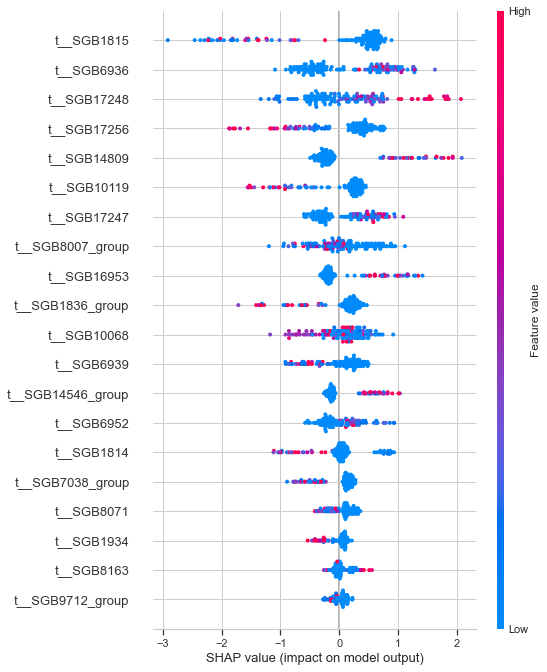

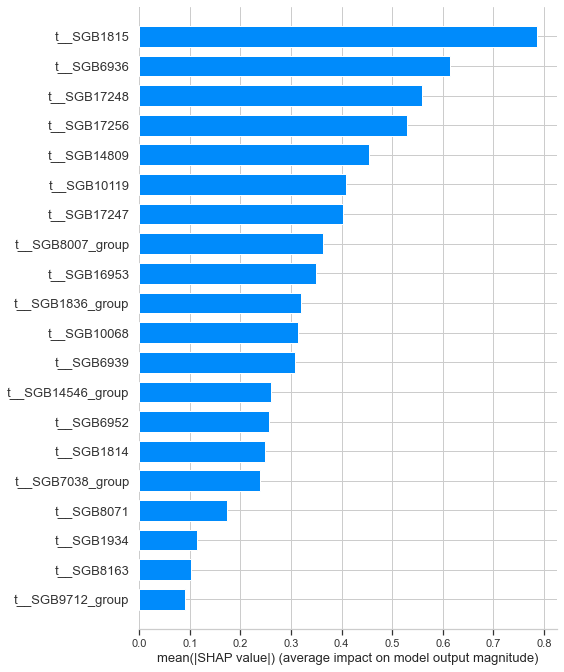

====infant_health_breathing_difficulties=====
===XGboost===
0    259
1     90
Name: infant_health_breathing_difficulties, dtype: int64
Average AUC: 0.4770378749790515
Standard Deviation: 0.0696297796293172


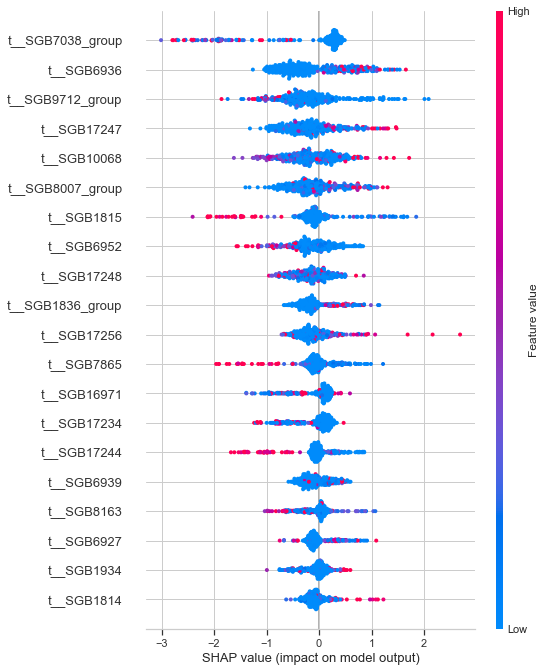

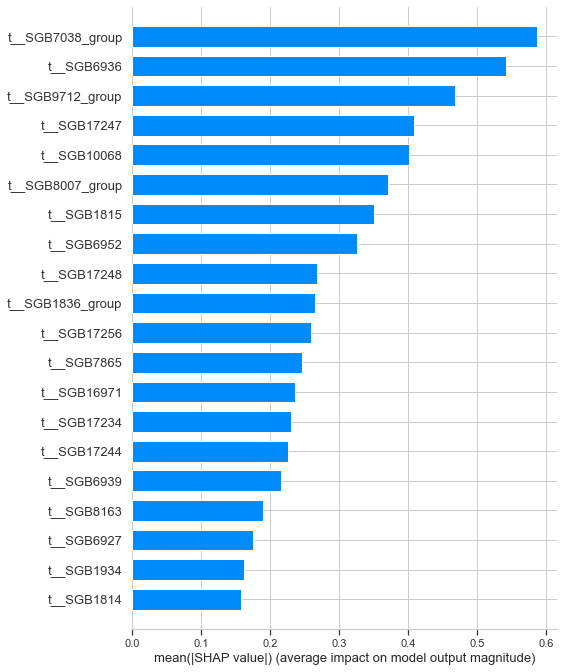

====infant_health_airway_nose_ear_throat_infection_freq=====
===XGboost===
0    110
1     57
Name: infant_health_airway_nose_ear_throat_infection_freq, dtype: int64
Average AUC: 0.6026997245179063
Standard Deviation: 0.09048529442489679


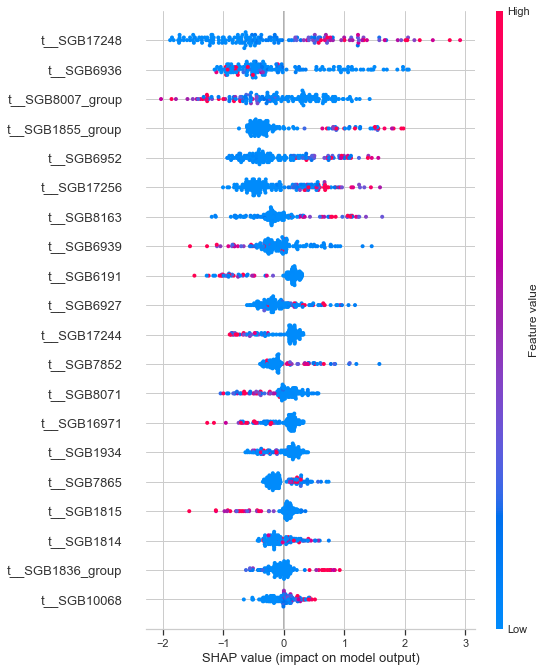

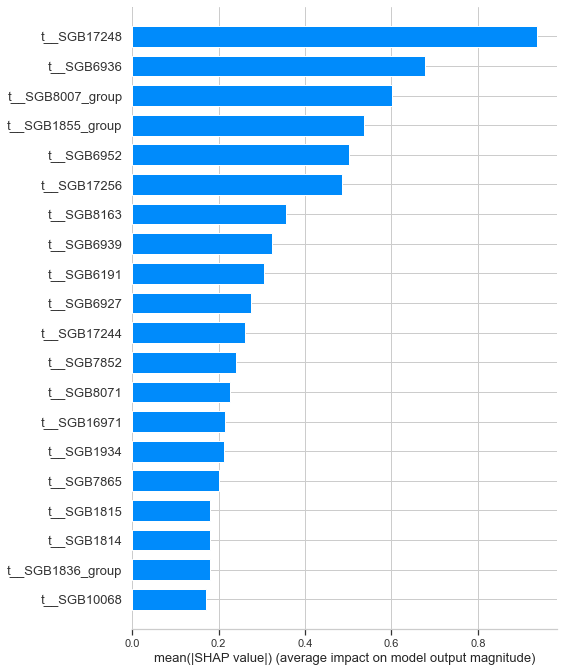

In [74]:
#arcsin transfrom
combined_shap, DF_AUC = Fit_model( DF2, Meta,  Fit = ["XGBoost"], Shap_file="shap_tables/Infant_arcsin.csv")
DF_AUC = DF_AUC.assign(transformation="argsin")

#clr transform
combined_shap_clr, DF_AUC_clr = Fit_model( DF2_clr, Meta, Fit = ["XGBoost"],  Shap_file="shap_tables/Infant_clr.csv")
DF_AUC_clr = DF_AUC_clr.assign(transformation="CLR")

#no transform
combined_shap_raw, DF_AUC_raw = Fit_model( DF2_none, Meta, Fit = ["XGBoost"],  Shap_file="shap_tables/Infant_raw.csv")
DF_AUC_raw = DF_AUC_raw.assign(transformation="None")

#Combine tables
DF_AUC = pd.concat([DF_AUC, DF_AUC_clr], axis=0)
DF_AUC = pd.concat([DF_AUC, DF_AUC_raw], axis=0)





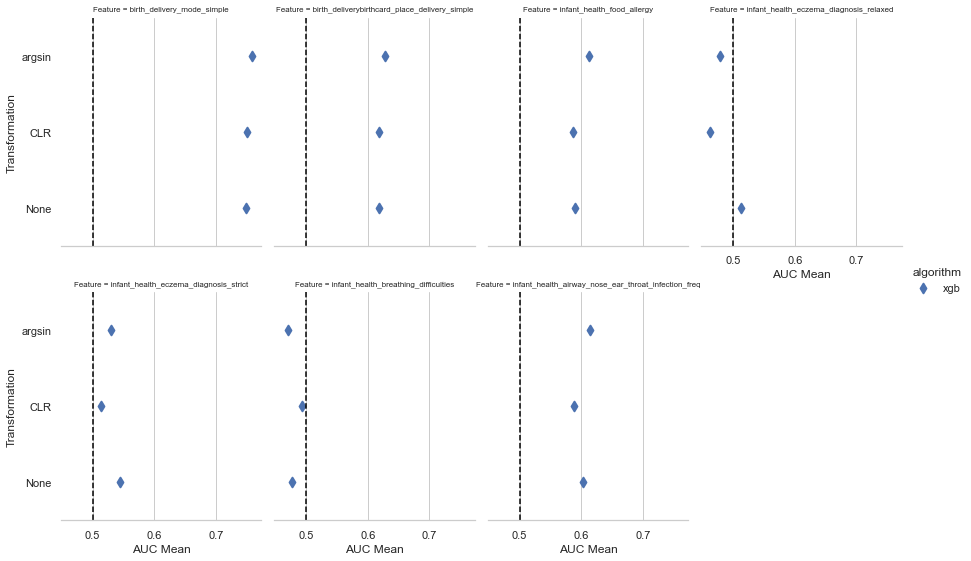

In [47]:
#Comparison of AUCs between transformations
def custom_error_bars(data):
    return [(mean - 2*std, mean + 2*std) for mean, std in zip(data["AUC_mean"], data["AUC_std"])]

def Plot(df):
    import seaborn as sns
    error_bars = 2 * df["AUC_std"]
    # Set up the plotting style
    sns.set(style="whitegrid")

    # Create the dot plot
    g = sns.catplot(
        data=df,
        x="AUC_mean",
        y="transformation",
        hue="algorithm",
        col="Feature",
        kind="point",
        dodge=True,
        markers="d",
        linestyles="",
        join=False,
        errorbarstring=custom_error_bars,  # Include error bars
        height=4,  # Adjust the height of each facet
        aspect=0.8,  # Adjust the aspect ratio
        col_wrap=4,  # Facets in two rows
        yerr=error_bars
    )

    # Add vertical line at x=0
    for ax in g.axes.flat:
        ax.axvline(x=0.5, color="black", linestyle="--")

    # Customize the axes and labels
    g.set_axis_labels("AUC Mean", "Transformation")
    g.set_titles("{col_name}")
    g.set_titles(size=8)
    g.despine(left=True)

    # Show the plot
    plt.show()


Plot(DF_AUC)

1    286
0    107
Name: birth_deliverybirthcard_place_delivery_simple, dtype: int64
Average AUC: 0.6003564292130537
Standard Deviation: 0.06472617387557066


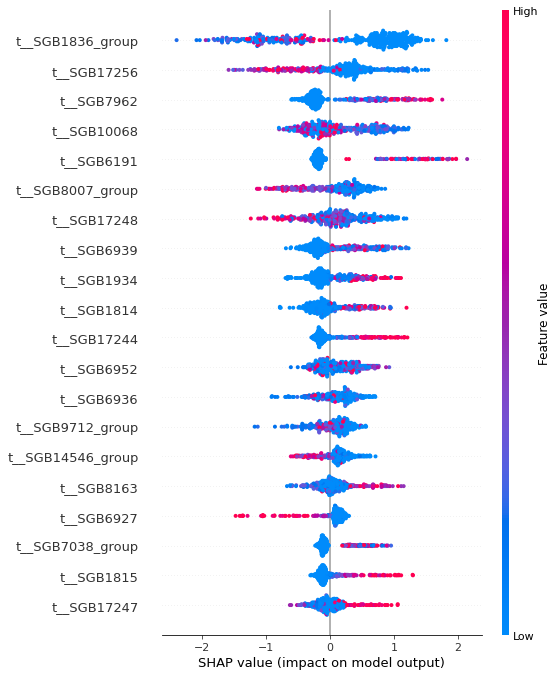

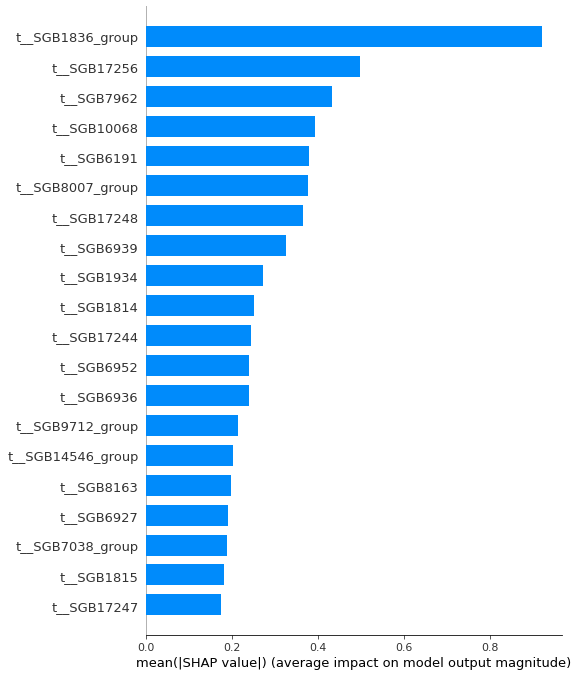

Feature_importance  \
t__SGB1836_group             0.921554   
t__SGB17256                  0.499112   
t__SGB7962                   0.433465   
t__SGB10068                  0.394360   
t__SGB6191                   0.379613   
t__SGB8007_group             0.378487   
t__SGB17248                  0.365987   
t__SGB6939                   0.327565   
t__SGB1934                   0.272785   
t__SGB1814                   0.252190   
t__SGB17244                  0.246311   
t__SGB6952                   0.240964   
t__SGB6936                   0.239785   
t__SGB9712_group             0.214379   
t__SGB14546_group            0.202922   
t__SGB8163                   0.197891   
t__SGB6927                   0.190841   
t__SGB7038_group             0.189574   
t__SGB1815                   0.182269   
t__SGB17247                  0.176170   
t__SGB10119                  0.171258   
t__SGB14809                  0.148310   
t__SGB7865                   0.114682   
t__SGB16971                  0.105101   
t__SGB17234                  0.093219   
t__SGB8071                   0.093045   
t__SGB1871                   0.090040   
t__SGB7852                   0.075013   
t__SGB16953                  0.065927   
t__SGB7144                   0.045711   
t__SGB1877                   0.036350   
t__SGB4584                   0.033386   
t__SGB1855_group             0.029182   

                                                       Phenotype  
t__SGB1836_group   birth_deliverybirthcard_place_delivery_simple  
t__SGB17256        birth_deliverybirthcard_place_delivery_simple  
t__SGB7962         birth_deliverybirthcard_place_delivery_simple  
t__SGB10068        birth_deliverybirthcard_place_delivery_simple  
t__SGB6191         birth_deliverybirthcard_place_delivery_simple  
t__SGB8007_group   birth_deliverybirthcard_place_delivery_simple  
t__SGB17248        birth_deliverybirthcard_place_delivery_simple  
t__SGB6939         birth_deliverybirthcard_place_delivery_simple  
t__SGB1934         birth_deliverybirthcard_place_delivery_simple  
t__SGB1814         birth_deliverybirthcard_place_delivery_simple  
t__SGB17244        birth_deliverybirthcard_place_delivery_simple  
t__SGB6952         birth_deliverybirthcard_place_delivery_simple  
t__SGB6936         birth_deliverybirthcard_place_delivery_simple  
t__SGB9712_group   birth_deliverybirthcard_place_delivery_simple  
t__SGB14546_group  birth_deliverybirthcard_place_delivery_simple  
t__SGB8163         birth_deliverybirthcard_place_delivery_simple  
t__SGB6927         birth_deliverybirthcard_place_delivery_simple  
t__SGB7038_group   birth_deliverybirthcard_place_delivery_simple  
t__SGB1815         birth_deliverybirthcard_place_delivery_simple  
t__SGB17247        birth_deliverybirthcard_place_delivery_simple  
t__SGB10119        birth_deliverybirthcard_place_delivery_simple  
t__SGB14809        birth_deliverybirthcard_place_delivery_simple  
t__SGB7865         birth_deliverybirthcard_place_delivery_simple  
t__SGB16971        birth_deliverybirthcard_place_delivery_simple  
t__SGB17234        birth_deliverybirthcard_place_delivery_simple  
t__SGB8071         birth_deliverybirthcard_place_delivery_simple  
t__SGB1871         birth_deliverybirthcard_place_delivery_simple  
t__SGB7852         birth_deliverybirthcard_place_delivery_simple  
t__SGB16953        birth_deliverybirthcard_place_delivery_simple  
t__SGB7144         birth_deliverybirthcard_place_delivery_simple  
t__SGB1877         birth_deliverybirthcard_place_delivery_simple  
t__SGB4584         birth_deliverybirthcard_place_delivery_simple  
t__SGB1855_group   birth_deliverybirthcard_place_delivery_simple

In [91]:
#birth_deliverybirthcard_place_delivery_simple is enriched in vaginal delivery. Remove CS deliver samples and repaeat assocation.

Meta_vd = Meta.drop(Meta[(Meta['birth_delivery_mode_simple'] == 'post_labor_CS') | (Meta['birth_delivery_mode_simple'].isna())].index)

Input_ml = Match_x_y(DF2, Meta_vd, "birth_deliverybirthcard_place_delivery_simple")
Input_ml["birth_deliverybirthcard_place_delivery_simple"] = Input_ml["birth_deliverybirthcard_place_delivery_simple"].map( {"home":0, "hospital":1} )
Input_ml = Input_ml[Input_ml["birth_deliverybirthcard_place_delivery_simple"].isin([0,1])]

Run_basic_model(Input_ml, "birth_deliverybirthcard_place_delivery_simple", CV=5, Model="xgb", Oversampling=False, N_repeats_cv=5 )

#We still get a similar AUC, meaning that the signal was not driven by VD

Now, we will fit the regression phenotypes:

In [92]:
Phenotype = 'infant_growth_standardized_weight_slope_kg'
stats_growth = Meta[Phenotype].agg(['mean', 'median', 'std', 'min', 'max'])
print(stats_growth)
#Remember to standarize in the pipeline.
Input_ml = Match_x_y(DF2, Meta, Phenotype)


Y = Input_ml[Phenotype]
X = Input_ml.drop(columns=[Phenotype, "NEXT_ID"])

model = xgb.XGBRegressor(random_state=4322) 
steps = [] #[('scaler', StandardScaler())]
steps.append(('regressor', model))
pipeline = Pipeline(steps)

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=23432)
scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='r2' )

print("Average R2:", scores.mean())
print("Standard Deviation:", scores.std())

mean        0.066793
median     -0.082203
std        16.109388
min       -45.437625
max       100.726183
Name: infant_growth_standardized_weight_slope_kg, dtype: float64
Average R2: -0.265013277887452
Standard Deviation: 0.11738903281441558


Finally, we will check multilevel prediction

In [93]:
phenotype_mapping = { "0_never":0, "1_once_twice":1, "2_three_to_five":2 }


Phenotype = "infant_health_airway_nose_ear_throat_infection_freq"

stats_frqInfection =  Meta["infant_health_airway_nose_ear_throat_infection_freq"].value_counts()
print(stats_frqInfection)
Meta_anal = Meta[Meta[Phenotype] != '3_six_times_more']

Input_ml = Match_x_y(DF2, Meta_anal, Phenotype)

Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1,2])]


np.random.seed(1234)
random.seed(233)
steps = []
    
Y = Input_ml[Phenotype]
X = Input_ml.drop(columns=[Phenotype, "NEXT_ID"])

classifier = xgb.XGBClassifier(random_state=2334)
 
steps.append(('classifier', classifier))
pipeline = Pipeline( steps )

# Create cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=12341)

# Run the cross-validation and get the accuracy scores
scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='roc_auc_ovr' )

# Print the average accuracy and standard deviation
print("Average AUC:", scores.mean())
print("Standard Deviation:", scores.std())




0_never             158
1_once_twice         67
2_three_to_five      15
3_six_times_more      5
Name: infant_health_airway_nose_ear_throat_infection_freq, dtype: int64
Average AUC: 0.5167080358817896
Standard Deviation: 0.11586992844792127


In [125]:
#save shap
combined_shap_merge = combined_shap.reset_index(inplace=False)
combined_shap_merge
#combined_shap = combined_shap.merge(Info_taxonomy, left_index=True, right_on='common_column')
combined_shap_merge = combined_shap_merge.merge(Info_taxonomy, left_on='index', right_on='Short_taxonomy', how='left')
combined_shap_merge.drop(columns= ["index", "Taxonomy_level"], inplace=True)
combined_shap_merge.to_csv("Shap_values.csv")

In [79]:
def HyperSelect_XGB(X = Input_ml , y = "infant_health_breathing_difficulties", N_repeats_cv = 1, CV=5, random_state=7644, Oversampling=False
):
    steps = []
    #Get Y and X
    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
    value_counts_df = Y.value_counts()
    #include oversampling strategy
    if Oversampling:
        oversample = SVMSMOTE()
        steps.append(("over", oversample))
    if not Oversampling:
        W = sum(Y) / len(Y)
    else: W = 1
    classifier = xgb.XGBClassifier(random_state=random_state, scale_pos_weight=W)

    steps.append(('classifier', classifier))
    pipeline = Pipeline(steps)


    # Define the hyperparameter grid for XGBoost
    param_grid = {
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }

    # Create cross-validation strategy
    cv = RepeatedStratifiedKFold(n_splits=CV, n_repeats=N_repeats_cv, random_state=random_state)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X, Y)

    # Print the best hyperparameters and corresponding performance
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best AUC Score:", grid_search.best_score_)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Print the average AUC and standard deviation from cross-validation using the best model
    scores = cross_val_score(best_model, X, Y, cv=cv, scoring='roc_auc')
    print("Average AUC with Best Model:", scores.mean())
    print("Standard Deviation:", scores.std())

Non-function version of fit, to play around

1    72
0    39
Name: infant_health_eczema_diagnosis_strict, dtype: int64


/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


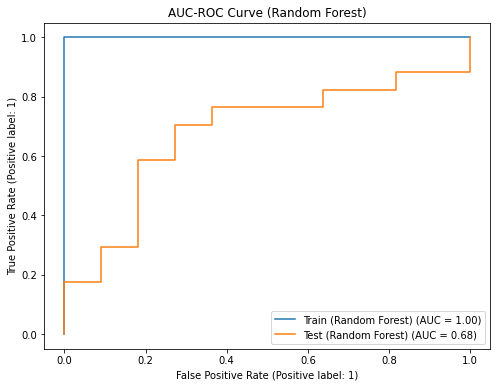

    1   0
1  72   0
0   0  39
Numbers:
1    72
0    39
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Numbers test
1    72
0    39
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Numbers train
1    17
0    11
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Confusion Matrix:


1  0
1  14  3
0   8  3

In [104]:
Phenotype = "infant_health_eczema_diagnosis_strict"
Input_ml = Match_x_y(DF2, Meta, Phenotype)
Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
#HyperSelect_XGB(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=True )


Y = Input_ml[Phenotype]
X = Input_ml.drop(columns=[Phenotype, "NEXT_ID"])
value_counts_df = Y.value_counts()


#model = xgb.XGBClassifier( colsample_bylevel=0.075, max_depth=6, learning_rate=0.0025, n_estimators=4000,subsample=0.6, min_child_weight=20. )
model = xgb.XGBClassifier(random_state=4322, scale_pos_weight=100*(value_counts_df[1]/sum(value_counts_df)), alpha =1, reg_lambda = 1 , gamma=1 )
#model = LogisticRegression(penalty='l1', C = 0.11,solver='liblinear', random_state=4343)
#model = RandomForestClassifier(n_estimators=500, random_state=3423423)

#{'max_depth': 10, 'learning_rate': 0.083248589398113, 'n_estimators': 184, 
# 'subsample': 0.8981097991959652, 'colsample_bylevel': 0.893813991379661,
# 'lambda': 3, 'alpha': 3, 'gamma': 3, 'scale_pos_weight': 56}
model = xgb.XGBClassifier(random_state=4322, scale_pos_weight= value_counts_df[1]/value_counts_df[0] )


steps = []
steps.append(('classifier', model))
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2234)

Oversampling = False
if Oversampling == True:
    oversample = SVMSMOTE()
    steps = [("over", oversample)] 
    pipeline = Pipeline(steps)
    X_train, y_train = pipeline.fit_resample(X_train, y_train)
value_counts_df = y_train.value_counts()
print(value_counts_df)
    
    
# Fit the model on the training data
model.fit(X_train, y_train)

# Plot the AUC-ROC curve for both training and testing sets
plt.figure(figsize=(8, 6))
plot_roc_curve(model, X_train, y_train, ax=plt.gca(), name="Train (Random Forest)")
plot_roc_curve(model, X_test, y_test, ax=plt.gca(), name="Test (Random Forest)")
plt.title("AUC-ROC Curve (Random Forest)")
plt.show()


cm_sum = np.zeros((len(value_counts_df), len(value_counts_df)), dtype=float)
    
Y_pred_Train = model.predict(X_train)
cm_sum_train = confusion_matrix(y_train, Y_pred_Train, labels=value_counts_df.index)
print(pd.DataFrame(cm_sum_train, index=value_counts_df.index, columns=value_counts_df.index))

    
Y_pred = model.predict(X_test)
cm_sum = confusion_matrix(y_test, Y_pred, labels=value_counts_df.index)

print("Numbers:")
print(value_counts_df)
print("Numbers test")
print(y_train.value_counts())
print("Numbers train")
print(y_test.value_counts())


print("Confusion Matrix:")
pd.DataFrame(cm_sum, index=value_counts_df.index, columns=value_counts_df.index)


Trying a genetic algorithm for hyperparameter selction. This is very time consuming. It is a deep search in the hyperparemeter space (inspired by biological rules of evolution).


In [79]:
def HyperSelect_genetic(X, y, Model="rf", random_state=876, CV=3 ):
    from sklearn_genetic import GASearchCV
    from sklearn_genetic import ExponentialAdapter
    from sklearn_genetic.space import Continuous, Categorical, Integer

    Y = X[y]
    X = X.drop(columns=[y, "NEXT_ID"])
     
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    value_counts_df = y_train.value_counts()

    
    mutation_adapter = ExponentialAdapter(initial_value=0.8, end_value=0.2, adaptive_rate=0.1)
    crossover_adapter = ExponentialAdapter(initial_value=0.2, end_value=0.8, adaptive_rate=0.1)

    if Model == "rf":
        param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30),
              'max_leaf_nodes': Integer(2, 35),
              'n_estimators': Integer(100, 300)}
        Model = RandomForestClassifier()
    elif Model == "xgb":
        param_grid = { 'max_depth': Integer(3, 10),
        'learning_rate': Continuous(0.01, 0.3,distribution='log-uniform' ),
        'n_estimators': Integer(100, 500),
        'subsample': Continuous(0.8, 1.0, distribution='log-uniform') ,
        'colsample_bylevel': Continuous(0.8, 1.0, distribution='log-uniform') ,
        'lambda': Integer(0,3),
        'alpha' : Integer(0,3),
        'gamma': Integer(0,3),
        'scale_pos_weight': Integer(0, int(100*(value_counts_df[1]/sum(value_counts_df)) ) )              
        }
        Model =  xgb.XGBClassifier(random_state=random_state)
    
    elif Model == "elasticnet":
        param_grid = { 'l1_ratio': Continuous(0, 1), 'C' : Continuous( 0.01, 100 ) } 
        Model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)  

        
    
    cv = StratifiedKFold(n_splits=CV, shuffle=False)
    evolved_estimator = GASearchCV(
            estimator = Model,
            cv=cv,
            verbose=1,
            scoring="roc_auc",
            population_size=20,
            generations=15,
            mutation_probability=mutation_adapter,
            crossover_probability=crossover_adapter,
            param_grid=param_grid,
            n_jobs=1,
        )

    evolved_estimator.fit(X_train, y_train) 
    print(evolved_estimator.best_params_)

    plt.figure(figsize=(8, 6))
    plot_roc_curve(evolved_estimator, X_train, y_train, ax=plt.gca(), name="Train (Random Forest)")
    plot_roc_curve(evolved_estimator, X_test, y_test, ax=plt.gca(), name="Test (Random Forest)")
    plt.title("AUC-ROC Curve (Random Forest)")
    plt.show()
    
    y_pred_proba = evolved_estimator.predict_proba(X_test)[:, 1]

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print("AUC Score:", auc_score)

====birth_delivery_mode_simple=====
0.0    368
1.0     46
Name: birth_delivery_mode_simple, dtype: int64
===XGboost===
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.682501	0.106114   	0.759899   	0.5        
1  	40    	0.751637	0.0103701  	0.770878   	0.729693   
2  	40    	0.762697	0.00846517 	0.776895   	0.746916   
3  	40    	0.773164	0.00999066 	0.785838   	0.754909   
4  	40    	0.782829	0.00664007 	0.796657   	0.764722   
5  	40    	0.78584 	0.00372201 	0.79149    	0.777203   
6  	40    	0.790156	0.00398027 	0.796657   	0.785838   
7  	40    	0.792452	0.00677475 	0.796657   	0.767228   
8  	40    	0.796066	0.00185808 	0.796737   	0.789204   
9  	40    	0.796673	3.1746e-05 	0.796737   	0.796657   
10 	40    	0.796693	3.94836e-05	0.796737   	0.796657   
11 	40    	0.796721	3.1746e-05 	0.796737   	0.796657   
12 	40    	0.795686	0.00370002 	0.796737   	0.780101   
13 	40    	0.796737	1.11022e-16	0.796737   	0.796737   
14 	40    	0.796737	1.11022e-16	0.796737 

/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/sergio/Documents/PhD/AutoEcoders/DeepLearning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


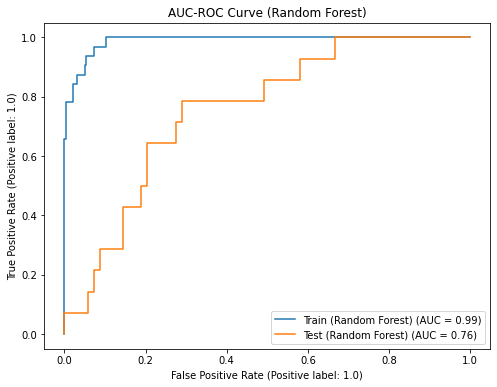

AUC Score: 0.756728778467909


In [81]:
phenotype_mapping = {'yes': 1, 'no': 0, "post_labor_CS":1, "VG":0, "home":0, "hospital":1}
#Test a naive classifier
Phenos = ["infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed", "infant_health_eczema_diagnosis_strict", "infant_health_breathing_difficulties" ]
Phenos = ["birth_delivery_mode_simple"]
for Phenotype in Phenos :
    print("===={P}=====".format(P=Phenotype))
    Input_ml = Match_x_y(DF2, Meta, Phenotype)
    Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
    Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1])]
    print(Input_ml[Phenotype].value_counts())
    print("===XGboost===")
    HyperSelect_genetic(Input_ml, Phenotype, CV=5, Model="xgb" )
    #print("===RF===")
    #Run_basic_model(Input_ml, Phenotype, CV=5, Model="rf", Oversampling=True )


Next, we will do some predictions using Mother data. So we will repeat the steps above.

In [7]:
DF_mothers, Info_taxonomy_mothers, Meta_mothers, Denominators_mothers = Read_data(Taxonomy_table = "Data/Taxonomy_for_prediction_mothersBirth.tsv",Table_GeomMean="Data/Table_GeomMeanMothers.tsv" )
Meta_mothers["NEXT_ID"] = Meta_mothers["next_id_mother"]

====infant_health_eczema_diagnosis_relaxed=====
===XGboost===
0    152
1     42
Name: infant_health_eczema_diagnosis_relaxed, dtype: int64
Average AUC: 0.46747491039426514
Standard Deviation: 0.08204625029205527


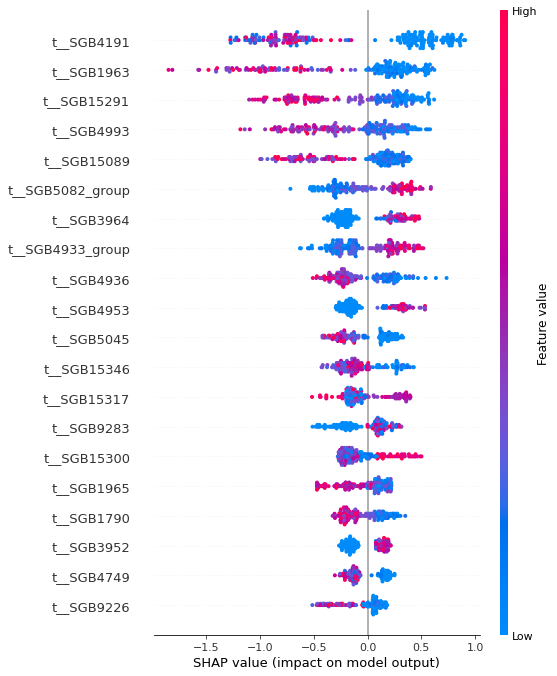

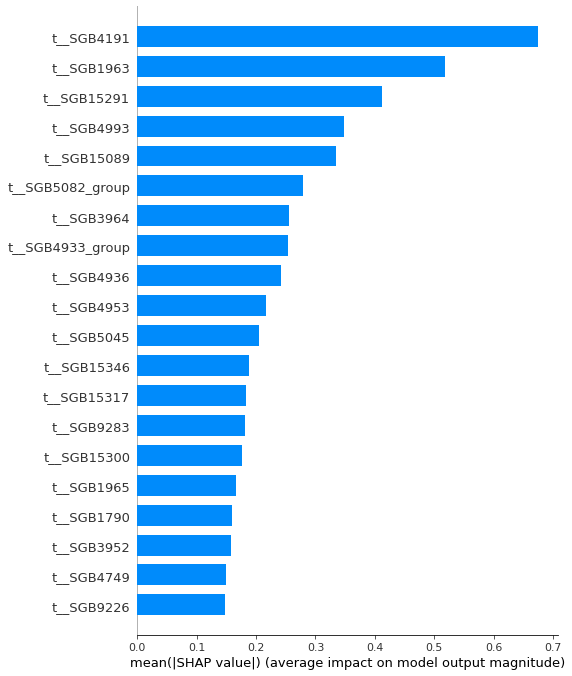

====infant_health_eczema_diagnosis_strict=====
===XGboost===
1    42
0    27
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.7468333333333333
Standard Deviation: 0.09567540933080602


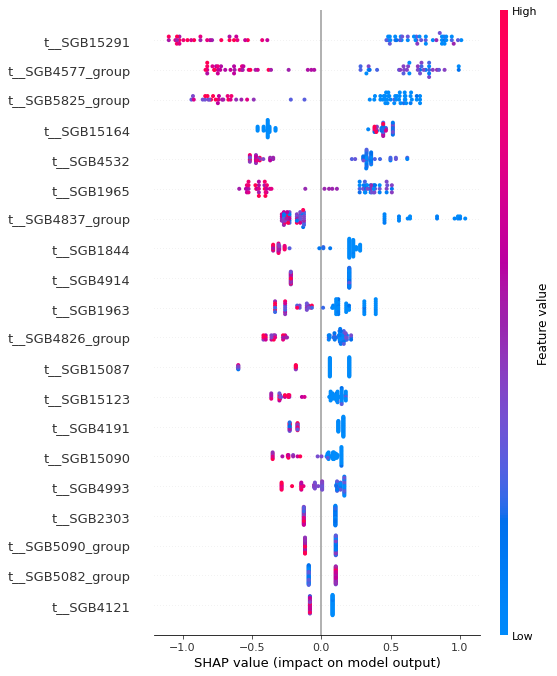

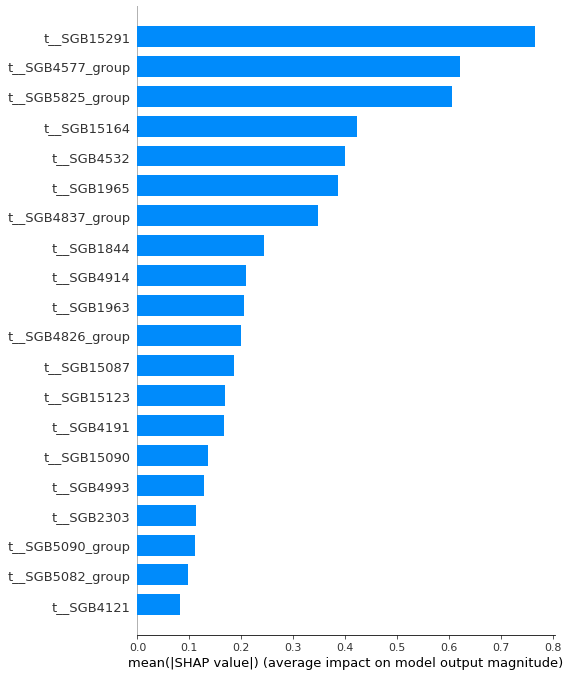

In [10]:
#DF2_mothers = Prepare_features_X(DF_mothers, info=Info_taxonomy_mothers , Level="t", Prev_threshold=0.2, Transform="clr", Den=Denominators_mothers, Pseudocount=1.819109e-05 )
DF2_mothers = Prepare_features_X(DF_mothers, info=Info_taxonomy_mothers, Level="t", Prev_threshold=0.2, Transform="arcsin")

phenotype_mapping = {'yes': 1, 'no': 0, "post_labor_CS":1, "VG":0, "home":0, "hospital":1, "0_never":0, "1_once_twice":1, "2_three_to_five":1,"3_six_times_more":1 }
Fit = ["XGBoost"]
#Iterate = ["birth_delivery_mode_simple", "birth_deliverybirthcard_place_delivery_simple", "infant_health_food_allergy", "infant_health_eczema_diagnosis_relaxed", "infant_health_eczema_diagnosis_strict", "infant_health_breathing_difficulties", "infant_health_airway_nose_ear_throat_infection_freq"]
Iterate = ["infant_health_eczema_diagnosis_relaxed","infant_health_eczema_diagnosis_strict" ]
combined_shap_mother = pd.DataFrame()

#Test naive classifiers (without much hyperparameter optimization, for that, check below)
for Phenotype in Iterate:
    print("===={P}=====".format(P=Phenotype))
    Input_ml = Match_x_y(DF2_mothers, Meta_mothers, Phenotype)
    Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
    Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1])]
    if "Plot" in Fit:
        Make_pcoa(Input_ml, "sqeuclidean", Phenotype, Check_eigen=True )
    if "Lasso" in Fit:
        print("===Lasso===")
        Run_basic_model(Input_ml, Phenotype, CV=5, Oversampling=False, Model="Lasso")
    if "XGBoost" in Fit:
        print("===XGboost===")
        Shap = Run_basic_model(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=False, N_repeats_cv=5 )
        combined_shap_mother = pd.concat([combined_shap_mother, Shap[0]], axis=0)
    if "RF" in Fit:
        print("===RF===")
        Run_basic_model(Input_ml, Phenotype, CV=5, Model="rf", Oversampling=False, N_repeats_cv=5 )
    if "Permanova" in Fit:
        print("===Permanova===")
        Check_Permanova(Input_ml, Phenotype)



In [46]:
#save shap
combined_shap_mother = combined_shap_mother.reset_index(inplace=False)
combined_shap_mother = combined_shap_mother.merge(Info_taxonomy_mothers, left_on='index', right_on='Short_taxonomy', how='left')
combined_shap_mother.drop(columns= ["index", "Taxonomy_level"], inplace=True)
combined_shap_mother.to_csv("Shap_values_motherPred.csv")

1    40
0    27
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.7701666666666667
Standard Deviation: 0.14569603060252992


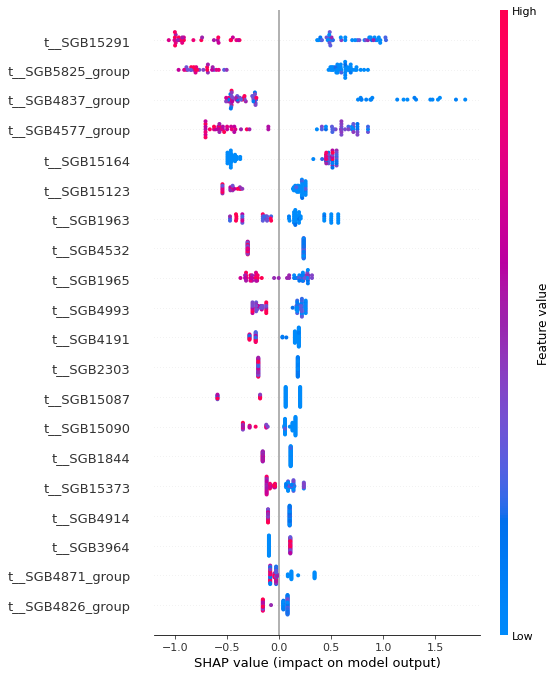

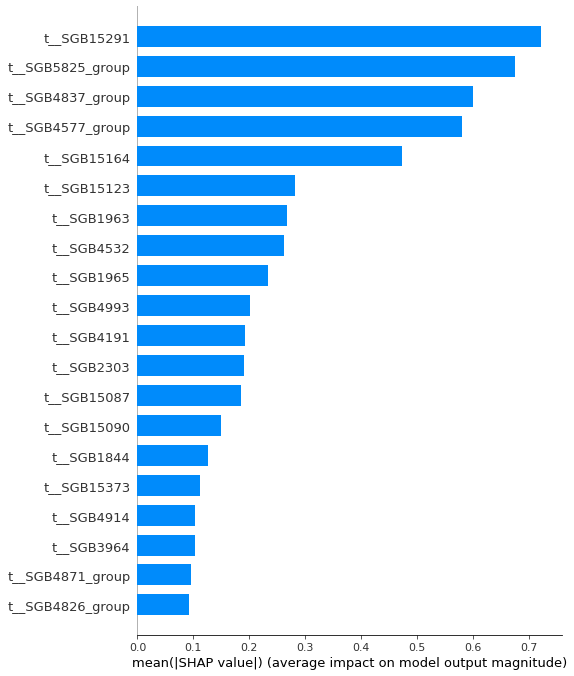

Boolean Series key will be reindexed to match DataFrame index.


1    40
0    27
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.7701666666666667
Standard Deviation: 0.14569603060252992


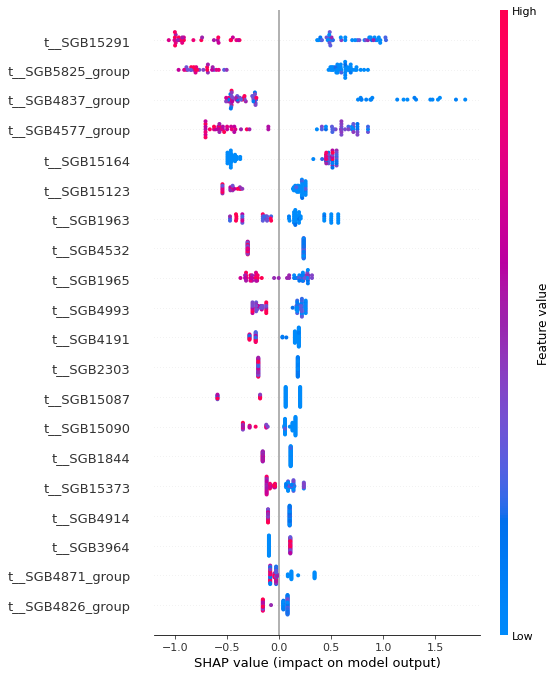

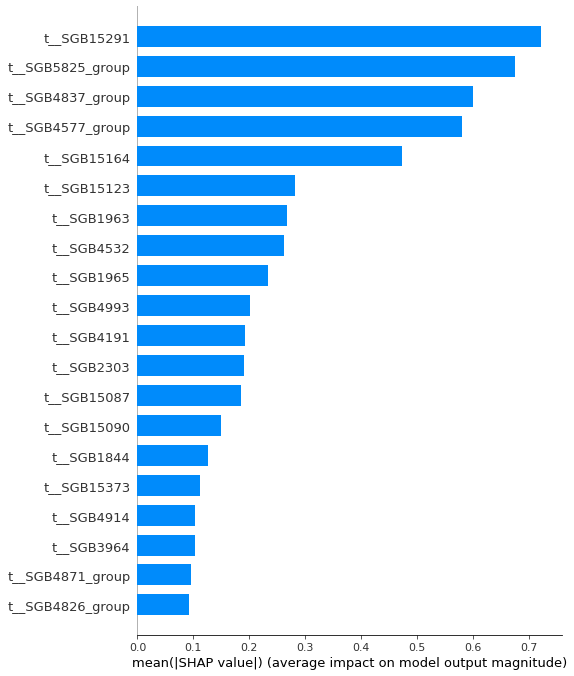

0    19
1    14
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.7330555555555556
Standard Deviation: 0.16889802606862087


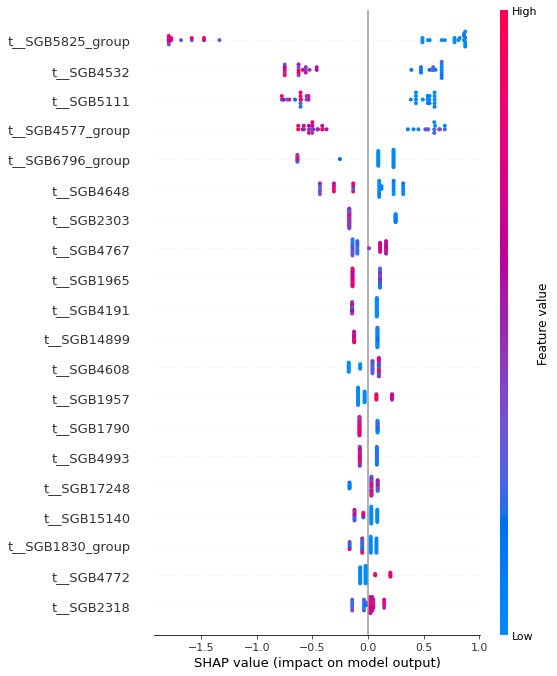

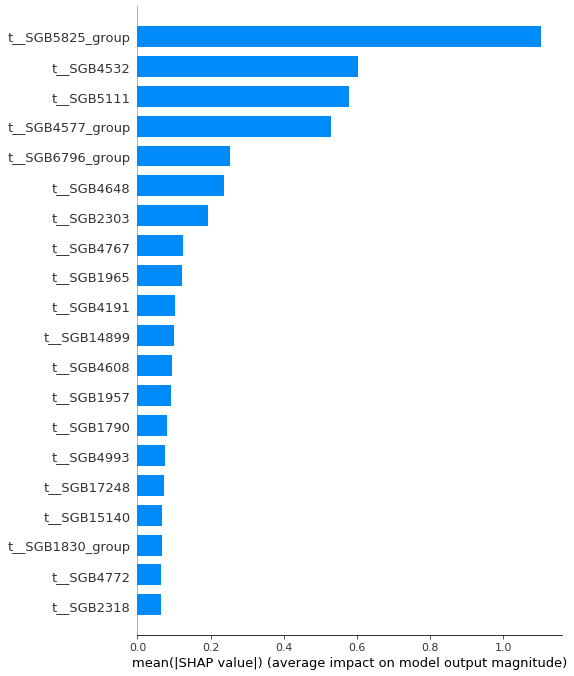

In [13]:
Phenotype = "infant_health_eczema_diagnosis_strict"
#Removal of C-section cases
Meta_vd = Meta_mothers.drop(Meta_mothers[(Meta_mothers['birth_delivery_mode_simple'] == 'home') | (Meta_mothers['birth_delivery_mode_simple'].isna() )].index)

Input_ml = Match_x_y(DF2_mothers, Meta_vd, Phenotype)
Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1])]
Shap = Run_basic_model(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=False, N_repeats_cv=5 )

#Hospital delivery and no C-section
Meta_vd = Meta_vd.drop(Meta_vd[(Meta_vd['birth_deliverybirthcard_place_delivery_simple'] == 'post_labor_CS') | (Meta_mothers['birth_deliverybirthcard_place_delivery_simple'].isna() )].index)
Input_ml = Match_x_y(DF2_mothers, Meta_vd, Phenotype)
Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1])]
Shap = Run_basic_model(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=False, N_repeats_cv=5 )


#Non-smoker mothers
Meta_vd = Meta_mothers.drop(Meta_mothers[(Meta_mothers['mother_health_smoked_one_whole_year_p18'] == 'yes') | (Meta_mothers['mother_health_smoked_one_whole_year_p18'].isna() )].index)

Input_ml = Match_x_y(DF2_mothers, Meta_vd, Phenotype)
Input_ml[Phenotype] = Input_ml[Phenotype].map(phenotype_mapping)
Input_ml = Input_ml[Input_ml[Phenotype].isin([0,1])]
Shap = Run_basic_model(Input_ml, Phenotype, CV=5, Model="xgb", Oversampling=False, N_repeats_cv=5 )




Plot ROC/AUC curve for each fold in Eczema diagnosis

In [65]:
import matplotlib.patches as patches
from sklearn.metrics import roc_curve,auc
from numpy import interp
from sklearn.metrics import RocCurveDisplay


# Create cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13433)
# Run the cross-validation and get the accuracy scores
scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='roc_auc' )

# Print the average accuracy and standard deviation
print("Average AUC:", scores.mean())
print("Standard Deviation:", scores.std())



Average AUC: 0.7636111111111111
Standard Deviation: 0.15203963096086512


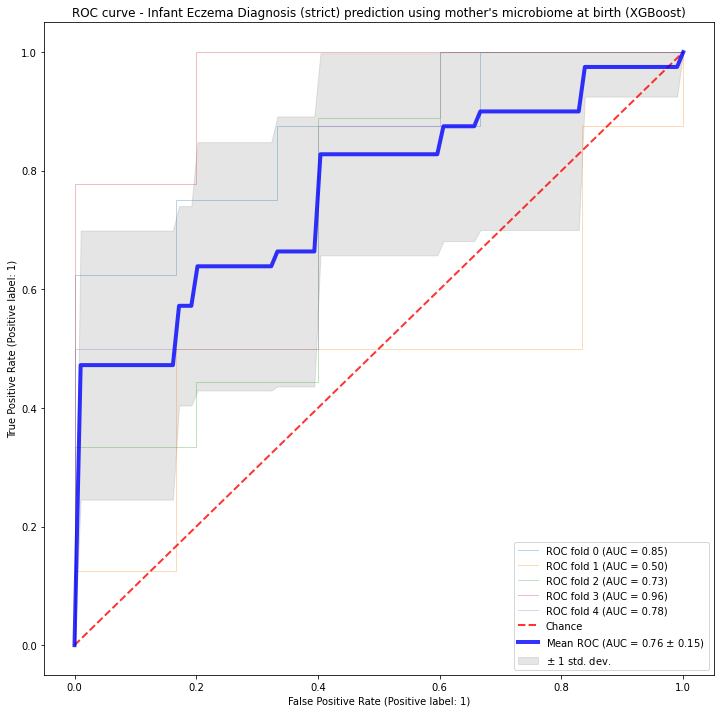

In [85]:

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=[12,12])
for i, (train, test) in enumerate(cv.split(X, Y)):
     model.fit(X.iloc[train], Y.iloc[train])
     viz = RocCurveDisplay.from_estimator(
         model,
         X.iloc[test],
         Y.iloc[test],
         name="ROC fold {}".format(i),
         alpha=0.3,
         lw=1,
         ax=ax,
     )
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr,mean_tpr,color="b",label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),lw=4,alpha=0.8,)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
     mean_fpr,
     tprs_lower,
     tprs_upper,
     color="grey",
     alpha=0.2,
     label=r"$\pm$ 1 std. dev.",
 )

ax.set(
     xlim=[-0.05, 1.05],
     ylim=[-0.05, 1.05],
     title="ROC curve - Infant Eczema Diagnosis (strict) prediction using mother's microbiome at birth (XGBoost)",
 )
ax.legend(loc="lower right")
plt.show()

====birth_delivery_mode_simple=====
===XGboost===
0.0    226
1.0      9
Name: birth_delivery_mode_simple, dtype: int64
Average AUC: 0.6743961352657005
Standard Deviation: 0.1717720060667423


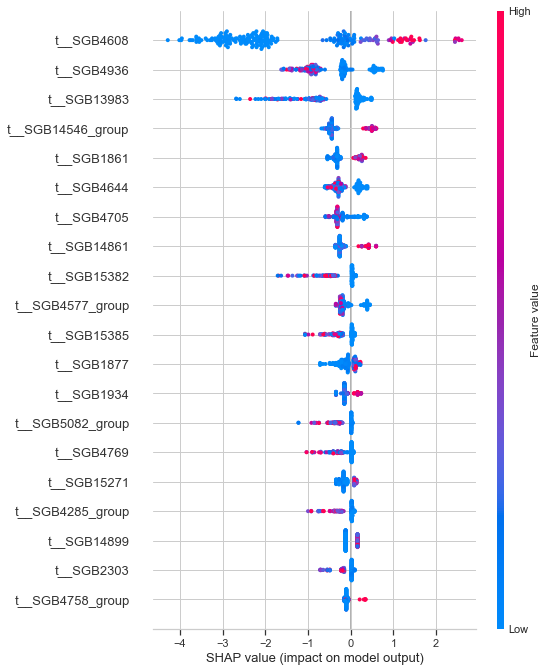

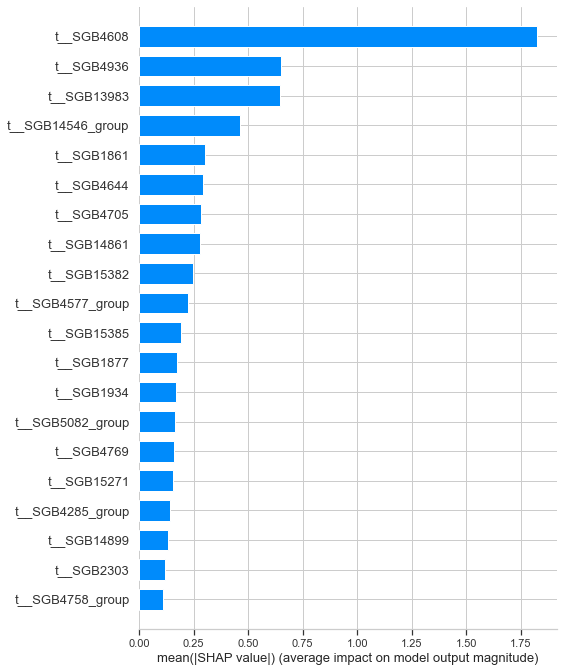

====birth_deliverybirthcard_place_delivery_simple=====
===XGboost===
1    167
0     76
Name: birth_deliverybirthcard_place_delivery_simple, dtype: int64
Average AUC: 0.5889973262032085
Standard Deviation: 0.07516949662792638


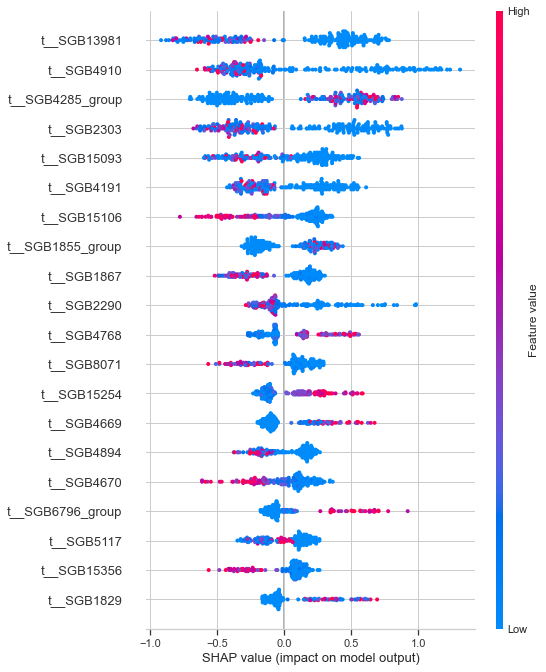

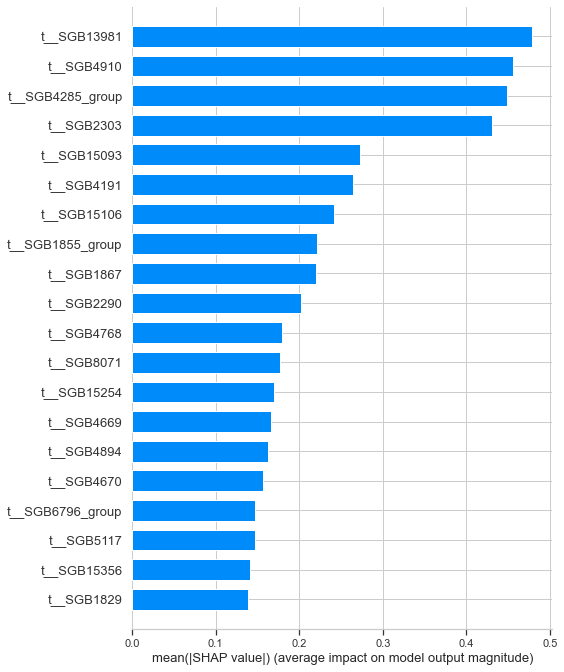

====infant_health_food_allergy=====
===XGboost===
0    172
1     25
Name: infant_health_food_allergy, dtype: int64
Average AUC: 0.49478991596638655
Standard Deviation: 0.11613293119433865


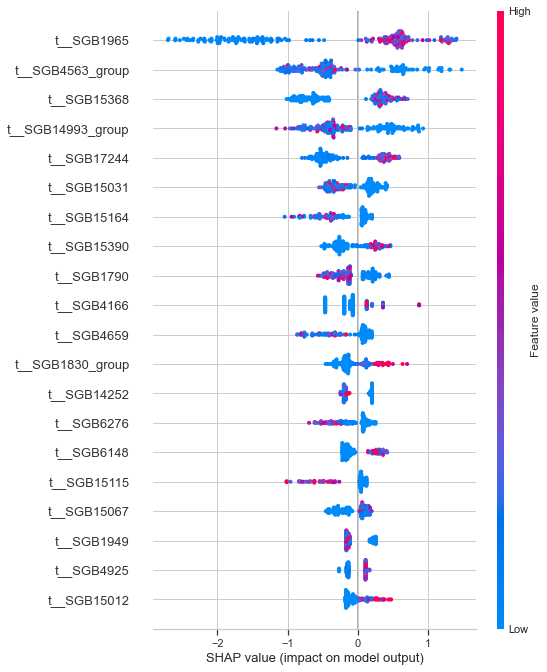

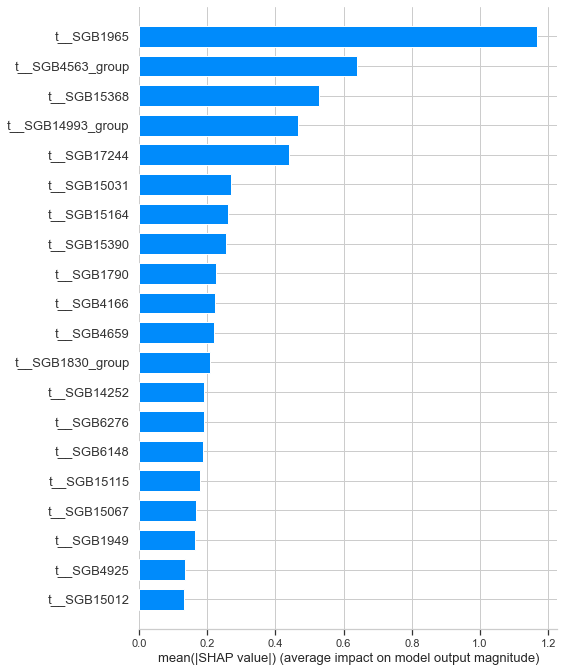

====infant_health_eczema_diagnosis_relaxed=====
===XGboost===
0    152
1     42
Name: infant_health_eczema_diagnosis_relaxed, dtype: int64
Average AUC: 0.4817443249701314
Standard Deviation: 0.10531945745113479


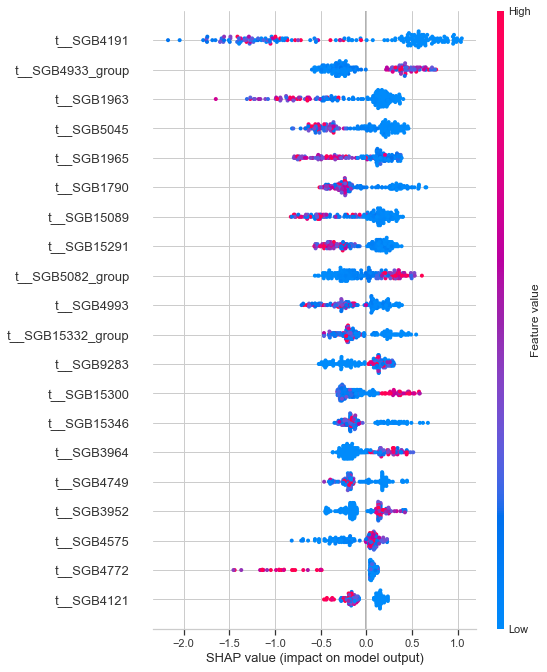

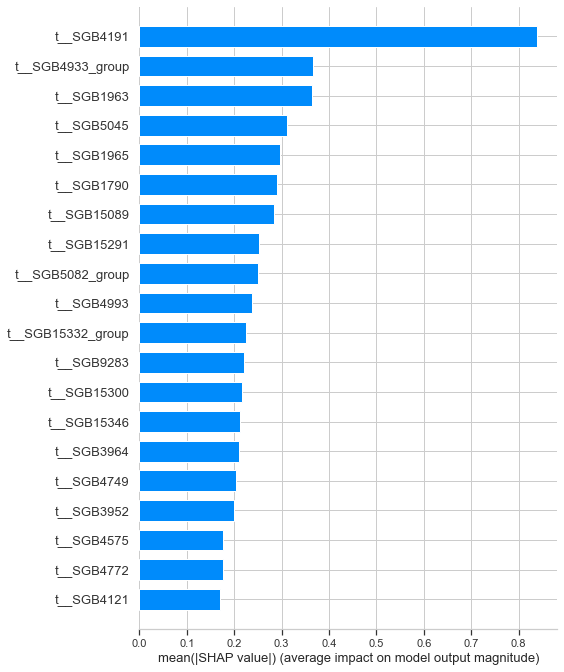

====infant_health_eczema_diagnosis_strict=====
===XGboost===
1    42
0    27
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.7753333333333333
Standard Deviation: 0.06735556105429062


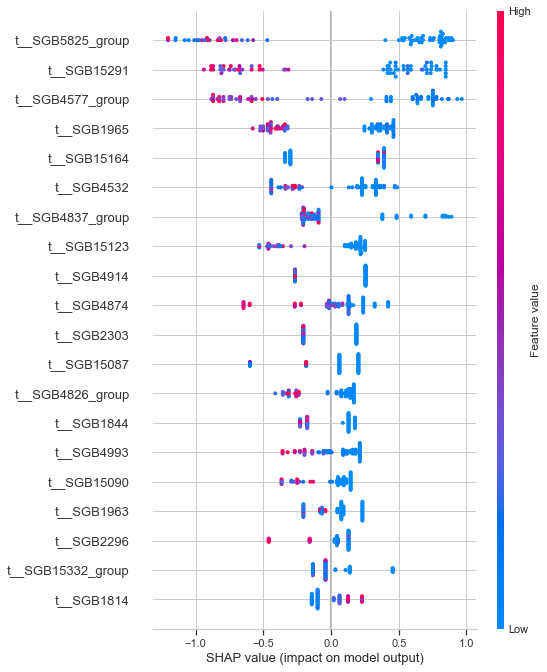

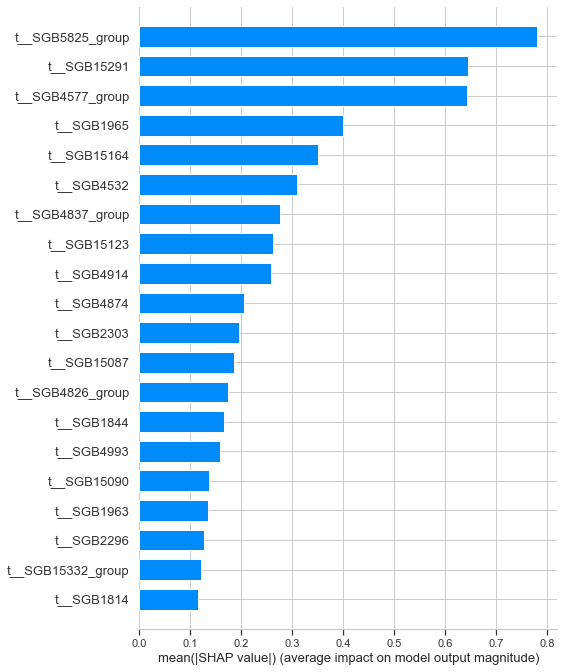

====infant_health_breathing_difficulties=====
===XGboost===
0    126
1     57
Name: infant_health_breathing_difficulties, dtype: int64
Average AUC: 0.560276923076923
Standard Deviation: 0.11015005171233709


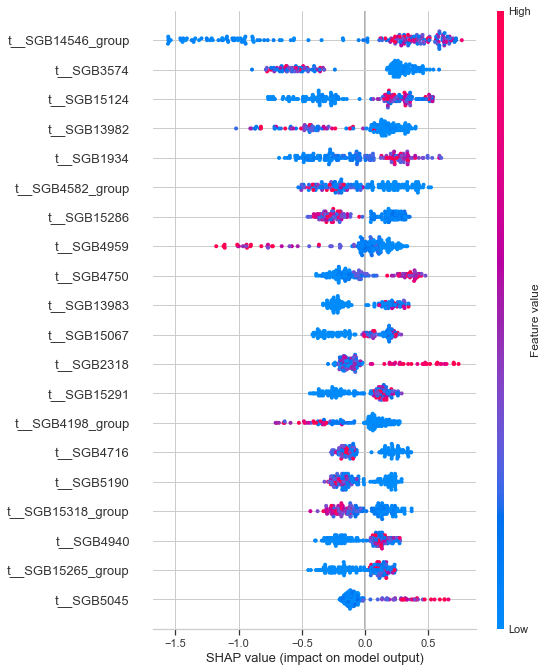

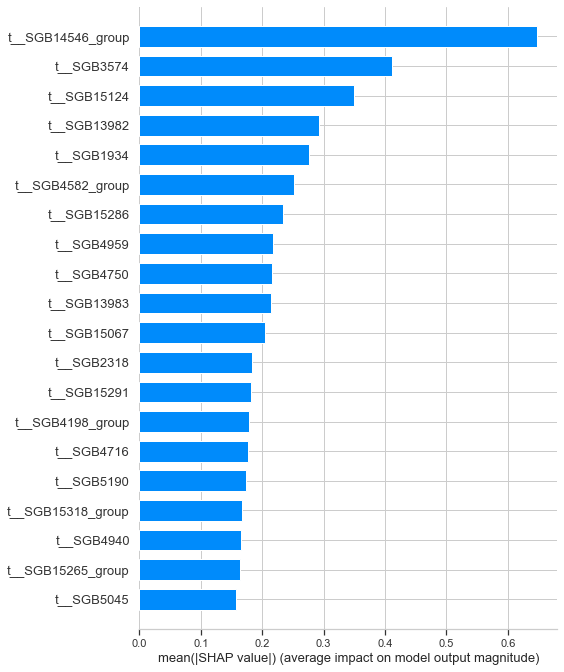

====infant_health_airway_nose_ear_throat_infection_freq=====
===XGboost===
0    53
1    34
Name: infant_health_airway_nose_ear_throat_infection_freq, dtype: int64
Average AUC: 0.46879653679653677
Standard Deviation: 0.12098419634428237


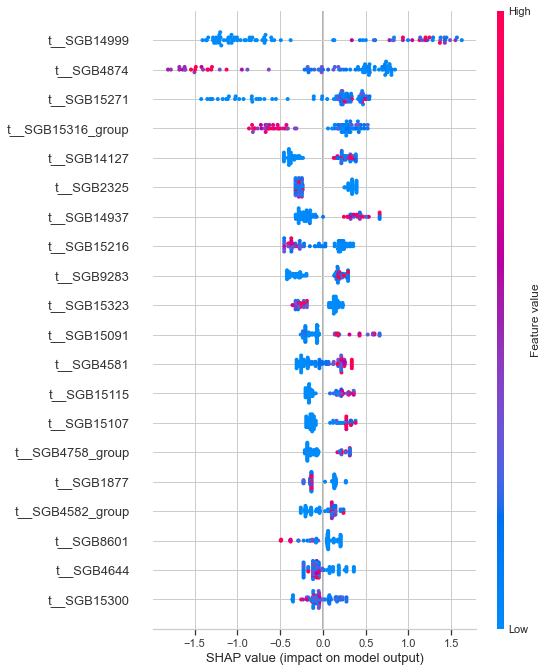

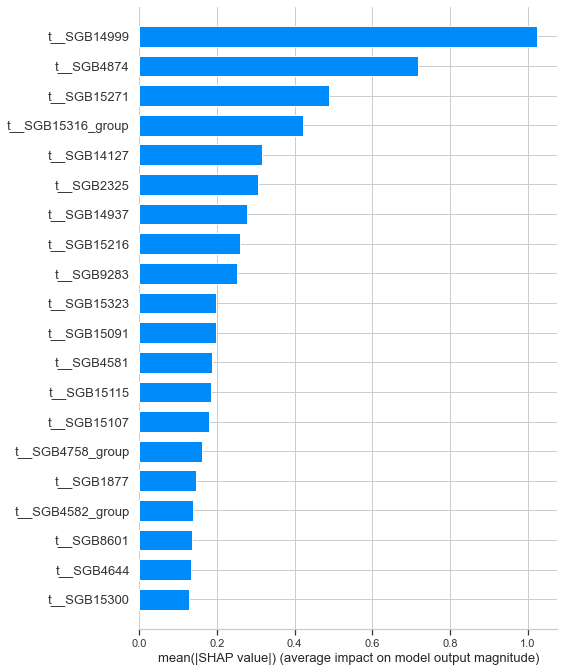

====birth_delivery_mode_simple=====
===XGboost===
0.0    226
1.0      9
Name: birth_delivery_mode_simple, dtype: int64
Average AUC: 0.6686183574879228
Standard Deviation: 0.22751374720951587


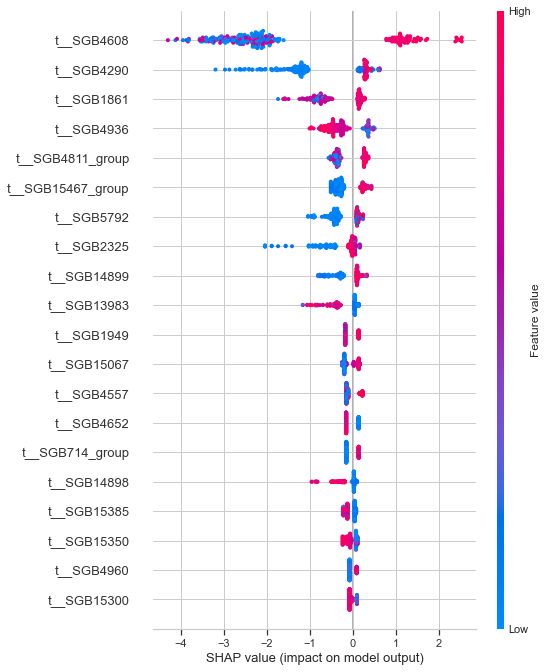

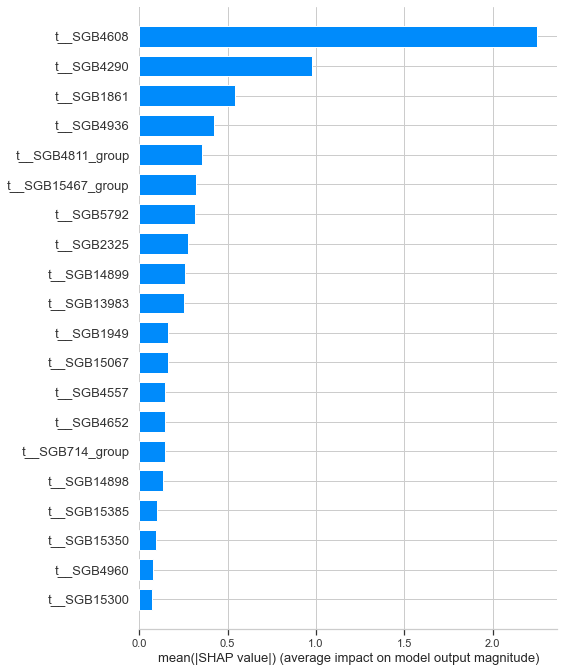

====birth_deliverybirthcard_place_delivery_simple=====
===XGboost===
1    167
0     76
Name: birth_deliverybirthcard_place_delivery_simple, dtype: int64
Average AUC: 0.5988764111705288
Standard Deviation: 0.06966911165283166


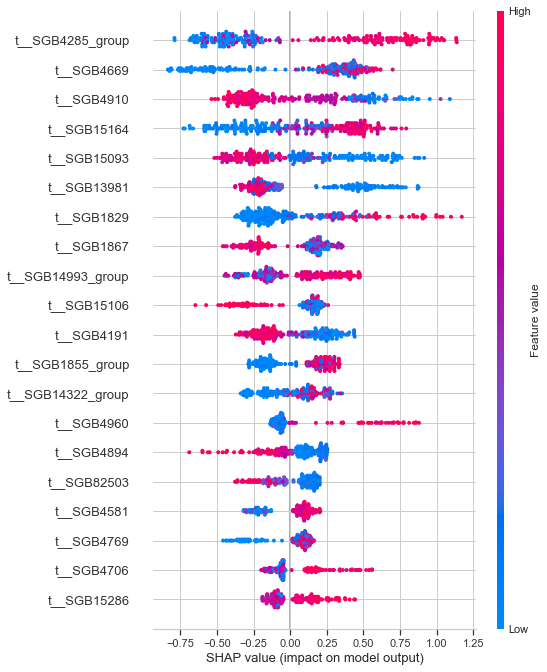

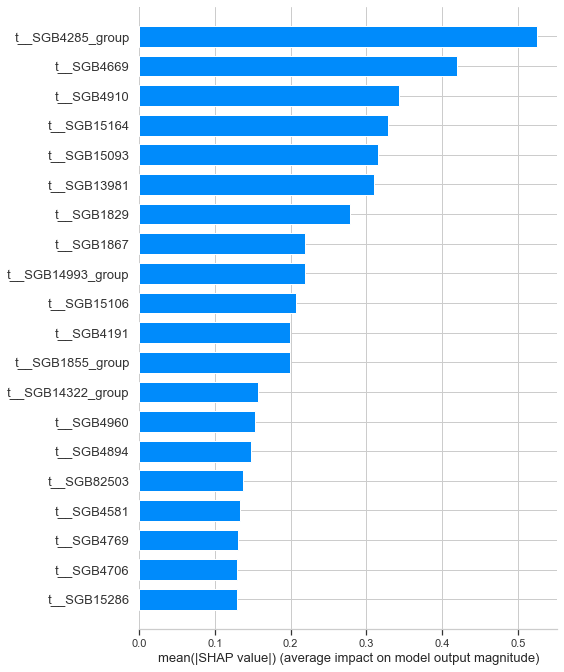

====infant_health_food_allergy=====
===XGboost===
0    172
1     25
Name: infant_health_food_allergy, dtype: int64
Average AUC: 0.48810756302521013
Standard Deviation: 0.09527112232740485


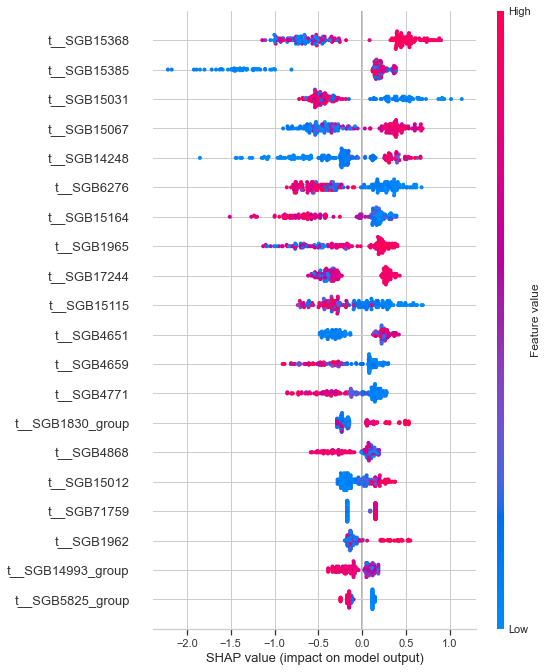

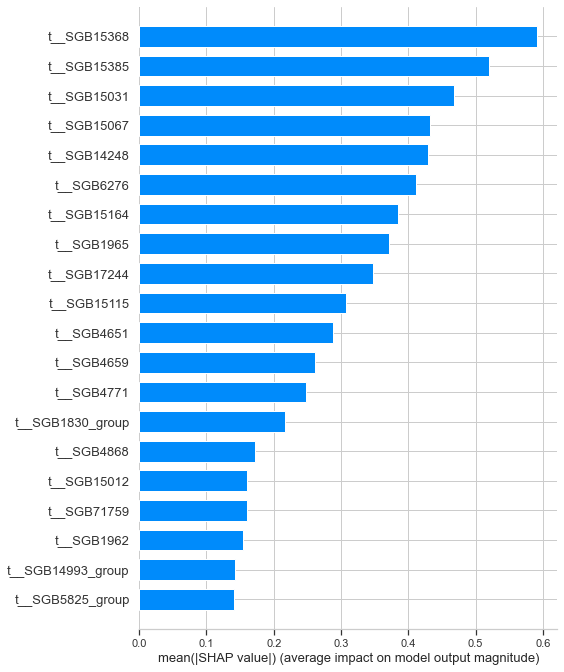

====infant_health_eczema_diagnosis_relaxed=====
===XGboost===
0    152
1     42
Name: infant_health_eczema_diagnosis_relaxed, dtype: int64
Average AUC: 0.43794683393070494
Standard Deviation: 0.09679966780885726


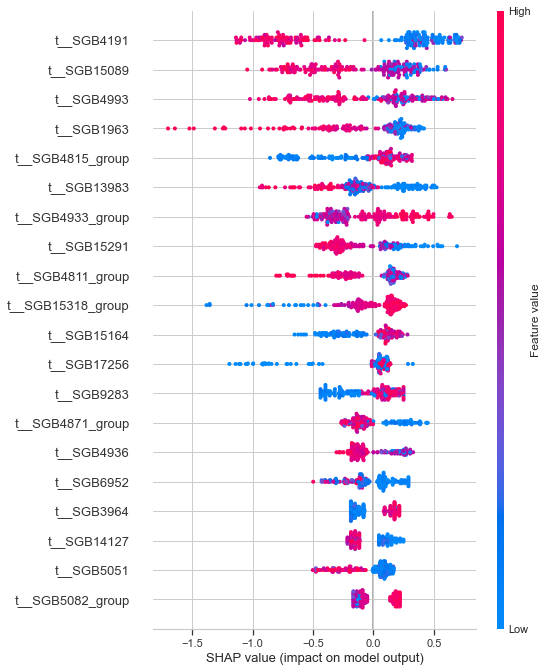

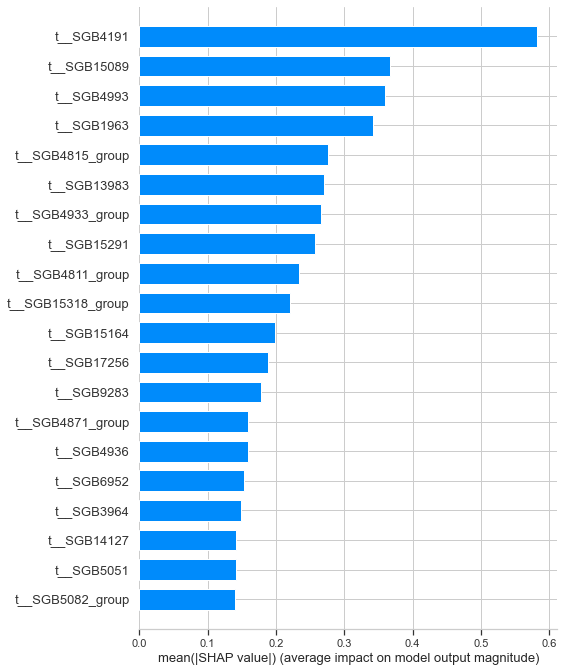

====infant_health_eczema_diagnosis_strict=====
===XGboost===
1    42
0    27
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.6084444444444445
Standard Deviation: 0.13549117323534904


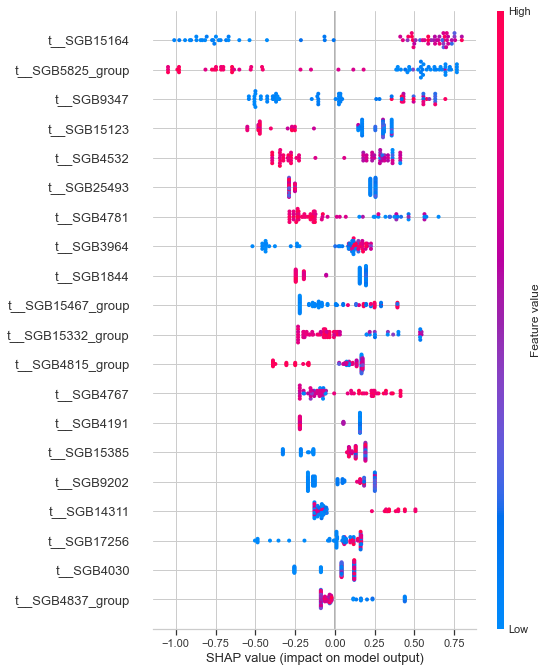

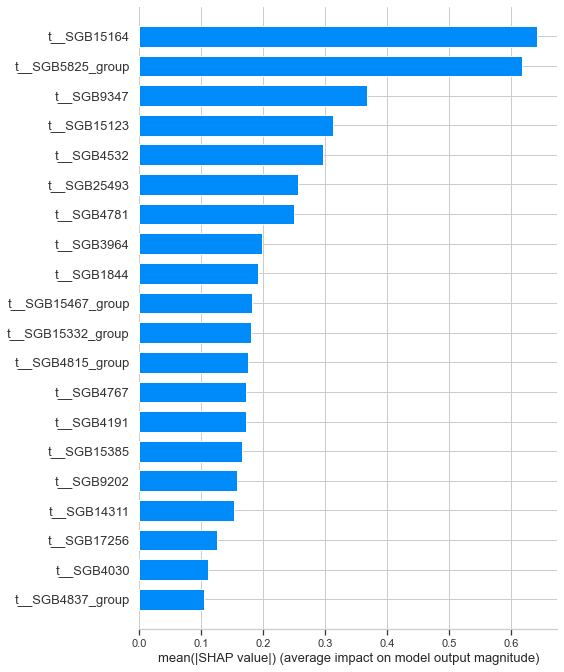

====infant_health_breathing_difficulties=====
===XGboost===
0    126
1     57
Name: infant_health_breathing_difficulties, dtype: int64
Average AUC: 0.5011841491841492
Standard Deviation: 0.07554681329563277


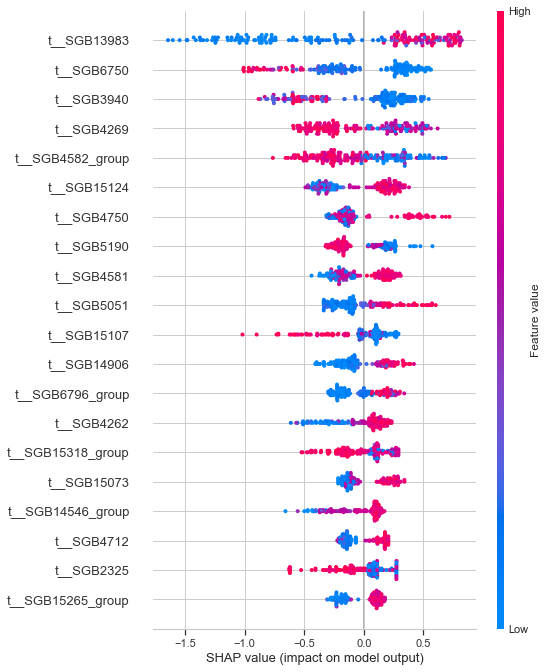

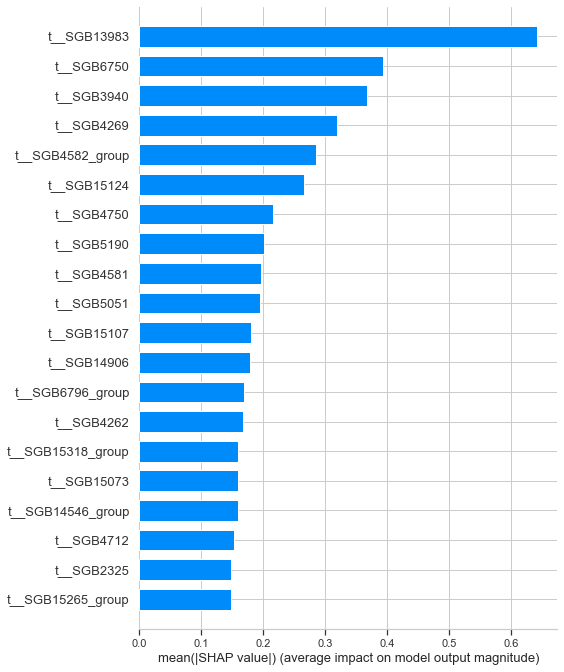

====infant_health_airway_nose_ear_throat_infection_freq=====
===XGboost===
0    53
1    34
Name: infant_health_airway_nose_ear_throat_infection_freq, dtype: int64
Average AUC: 0.44786147186147185
Standard Deviation: 0.1241797558286


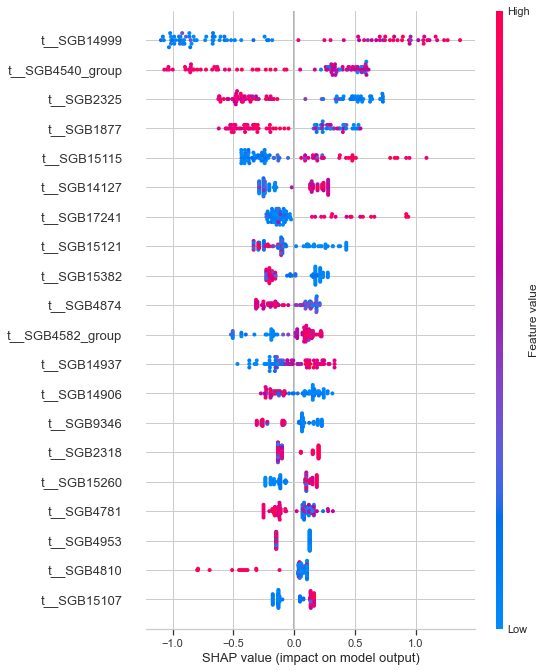

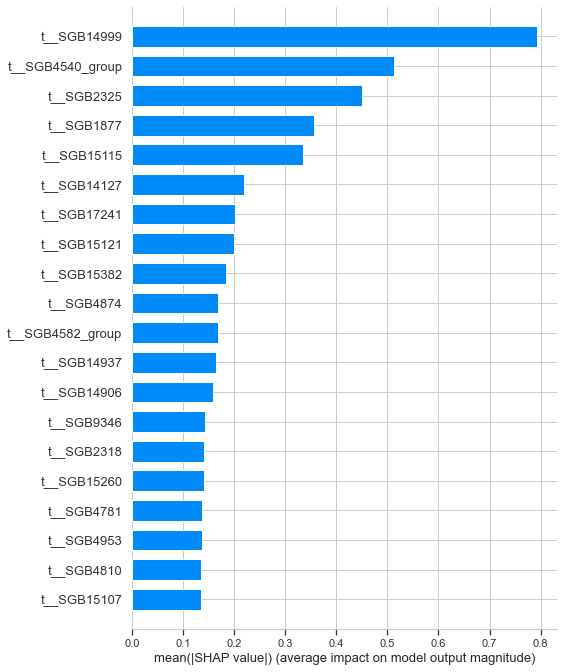

====birth_delivery_mode_simple=====
===XGboost===
0.0    226
1.0      9
Name: birth_delivery_mode_simple, dtype: int64
Average AUC: 0.6743961352657005
Standard Deviation: 0.1717720060667423


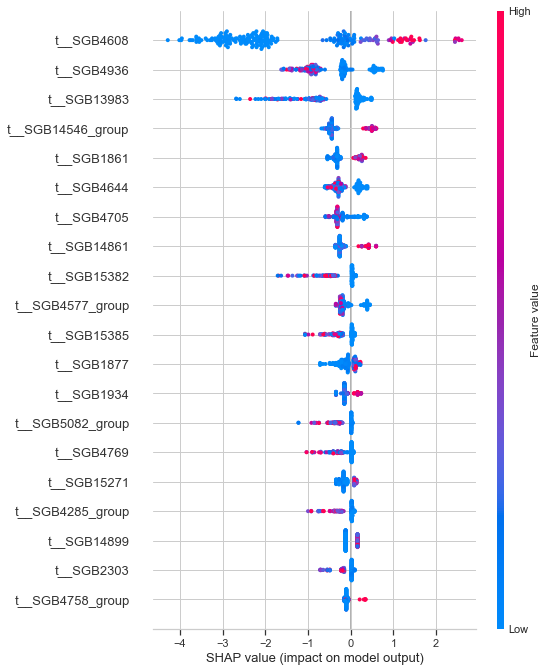

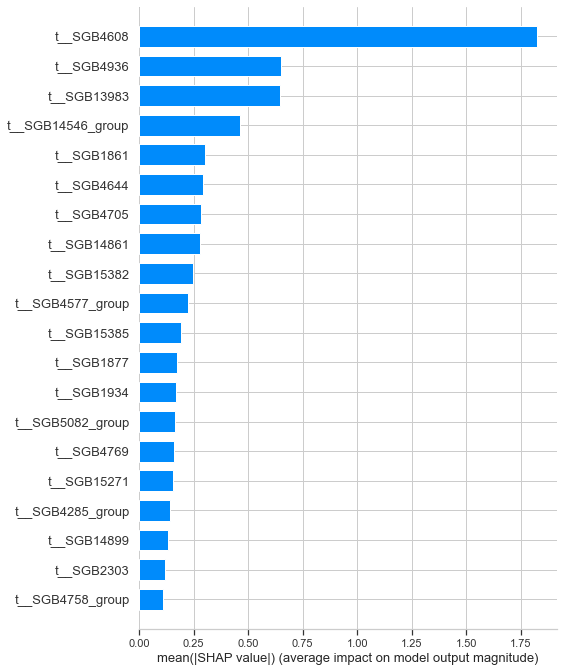

====birth_deliverybirthcard_place_delivery_simple=====
===XGboost===
1    167
0     76
Name: birth_deliverybirthcard_place_delivery_simple, dtype: int64
Average AUC: 0.5889973262032085
Standard Deviation: 0.07516949662792638


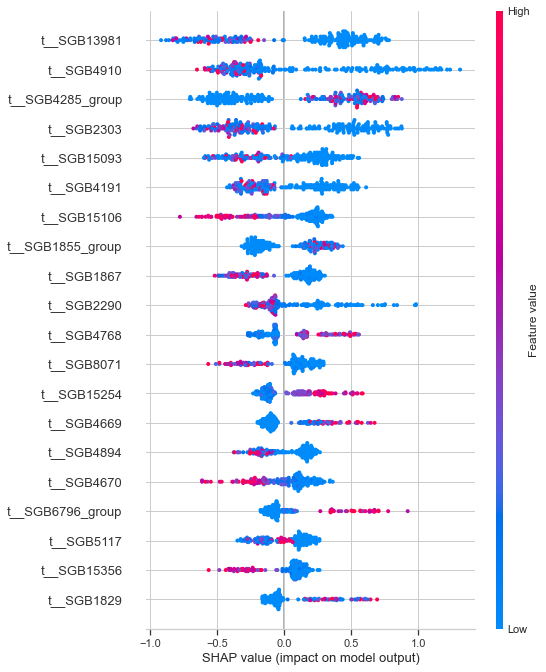

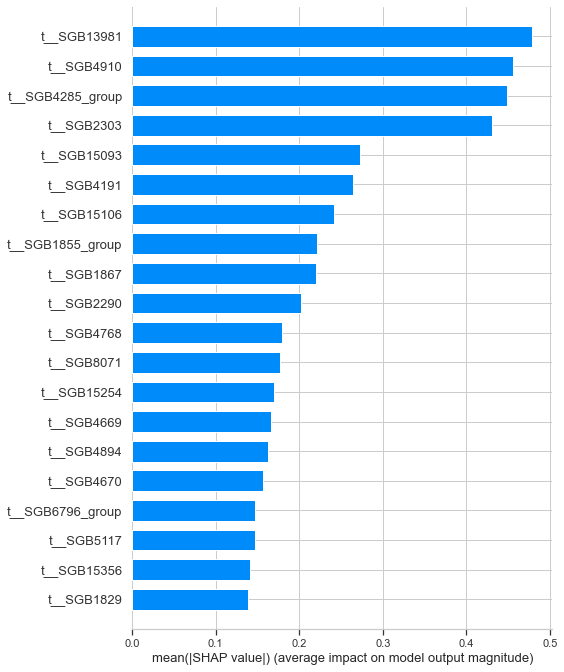

====infant_health_food_allergy=====
===XGboost===
0    172
1     25
Name: infant_health_food_allergy, dtype: int64
Average AUC: 0.49478991596638655
Standard Deviation: 0.11613293119433865


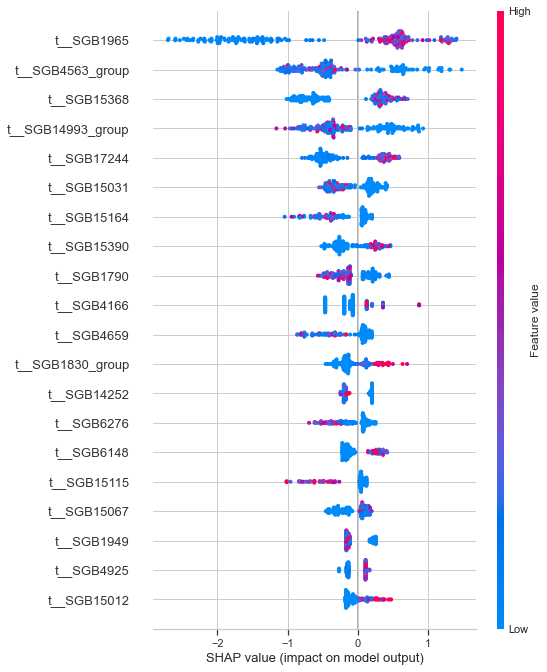

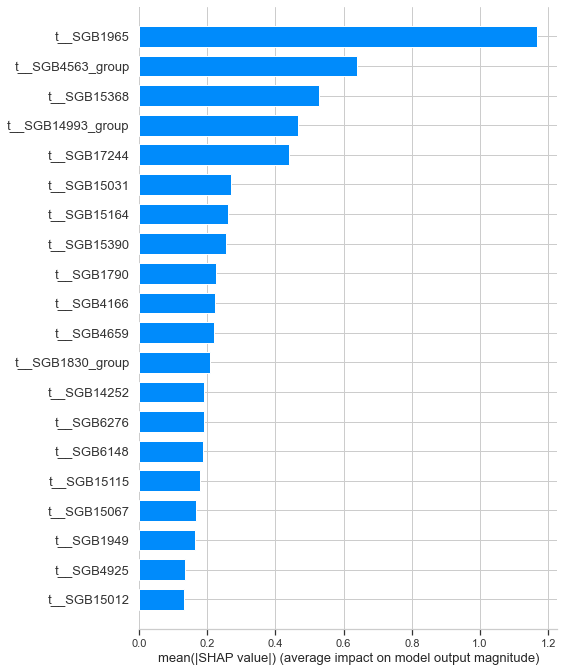

====infant_health_eczema_diagnosis_relaxed=====
===XGboost===
0    152
1     42
Name: infant_health_eczema_diagnosis_relaxed, dtype: int64
Average AUC: 0.4817443249701314
Standard Deviation: 0.10531945745113479


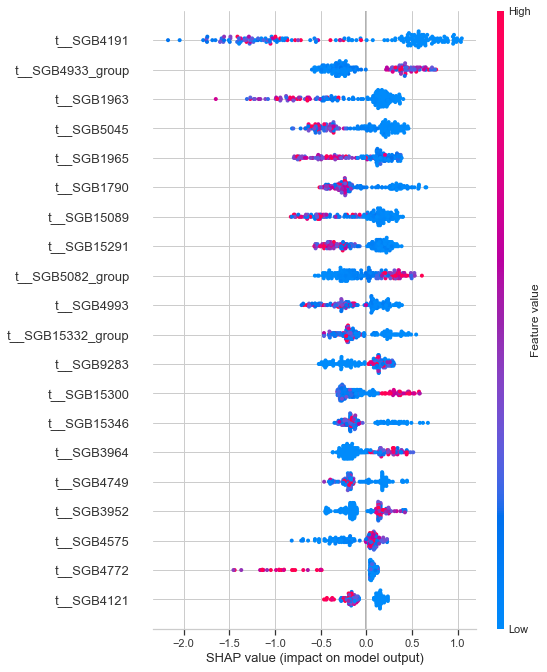

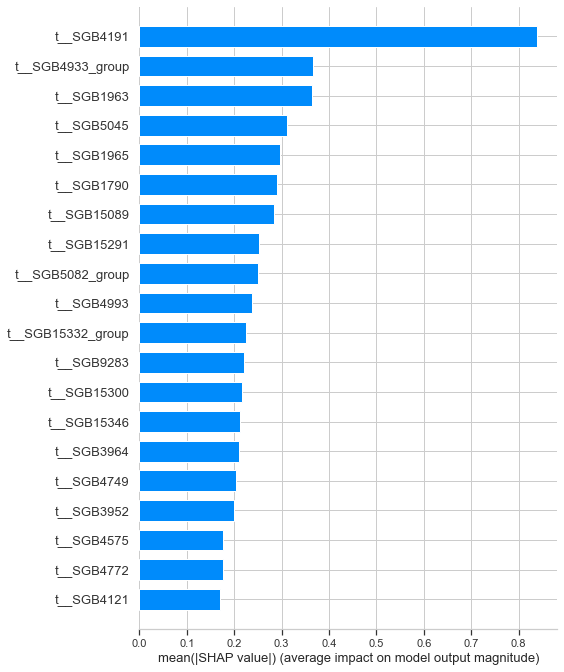

====infant_health_eczema_diagnosis_strict=====
===XGboost===
1    42
0    27
Name: infant_health_eczema_diagnosis_strict, dtype: int64
Average AUC: 0.7753333333333333
Standard Deviation: 0.06735556105429062


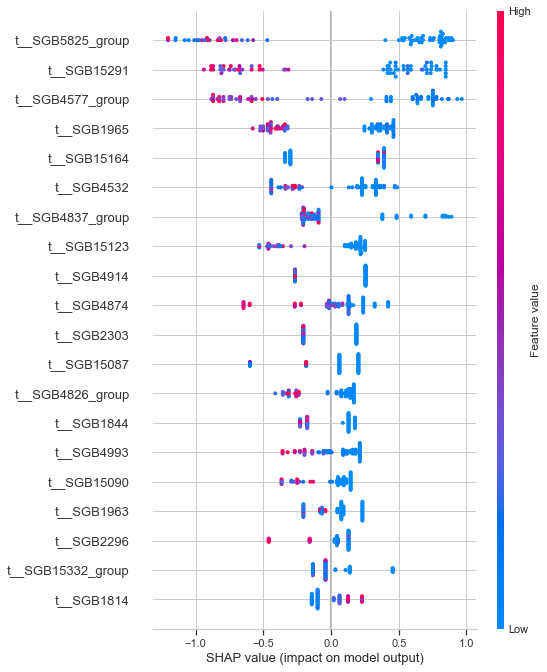

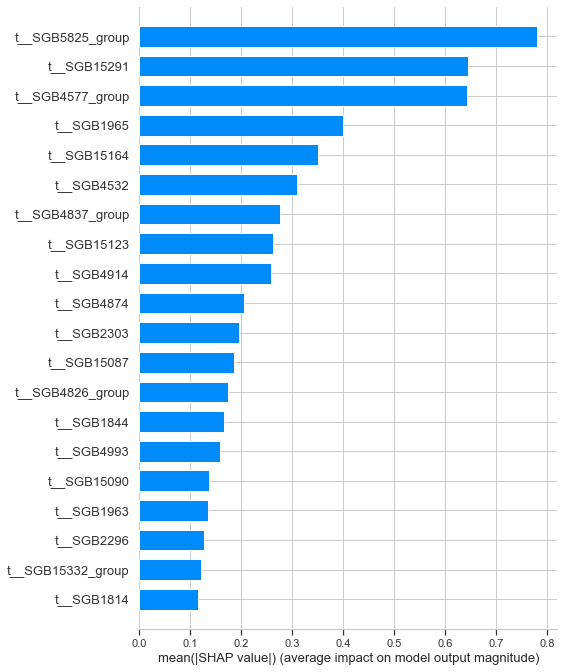

====infant_health_breathing_difficulties=====
===XGboost===
0    126
1     57
Name: infant_health_breathing_difficulties, dtype: int64
Average AUC: 0.560276923076923
Standard Deviation: 0.11015005171233709


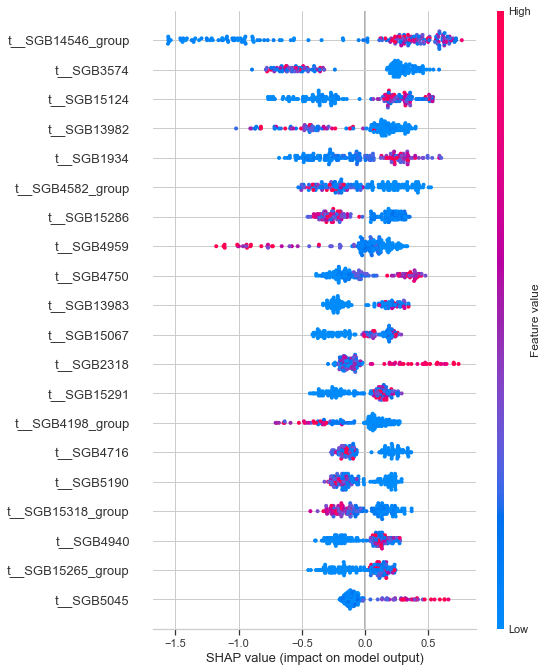

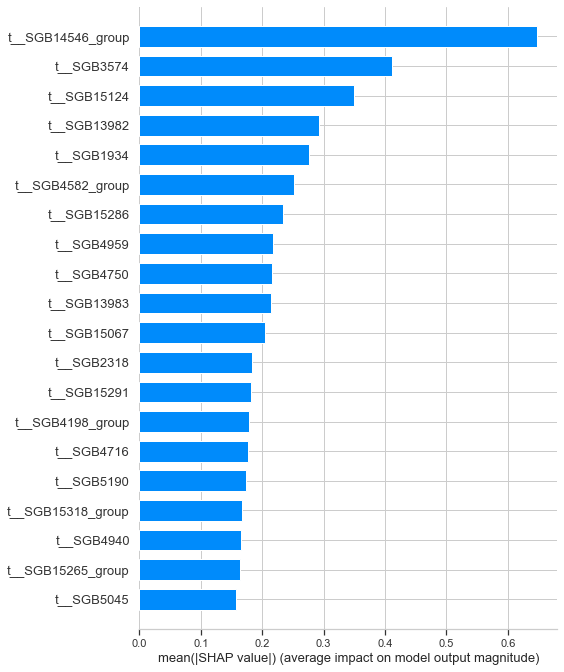

====infant_health_airway_nose_ear_throat_infection_freq=====
===XGboost===
0    53
1    34
Name: infant_health_airway_nose_ear_throat_infection_freq, dtype: int64
Average AUC: 0.46879653679653677
Standard Deviation: 0.12098419634428237


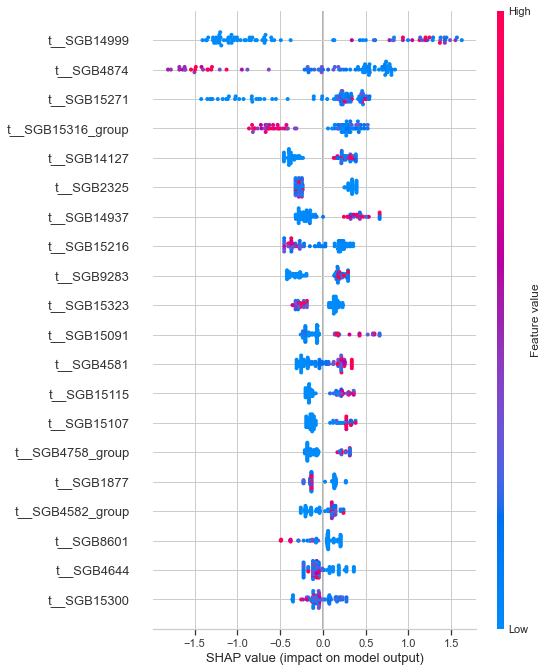

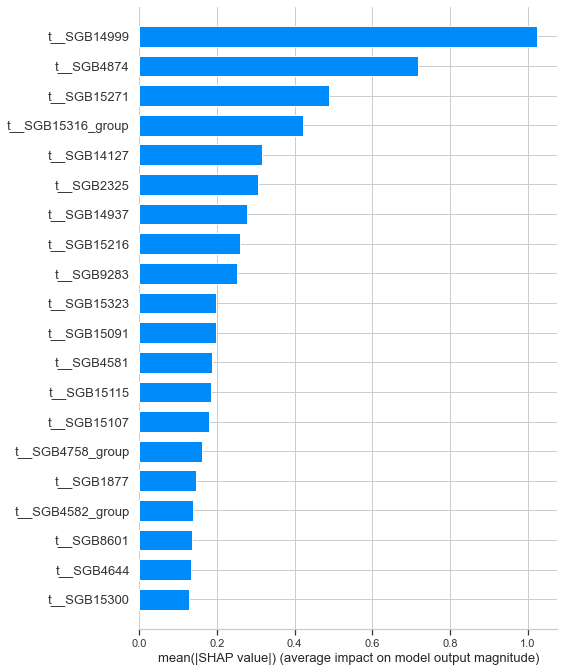

In [75]:
DF2_mothers_none = Prepare_features_X(DF_mothers, info=Info_taxonomy_mothers, Level="t", Prev_threshold=0.2, Transform=None)
DF2_mothers_clr = Prepare_features_X(DF_mothers, info=Info_taxonomy_mothers, Level="t", Prev_threshold=0.2, Transform="clr",Den=Denominators_mothers, Pseudocount=1.819109e-05 )
DF2_mothers = Prepare_features_X(DF_mothers, info=Info_taxonomy_mothers, Level="t", Prev_threshold=0.2, Transform="argsin")


#arcsin transfrom
combined_shap_mothers, DF_AUC_mothers = Fit_model( DF2_mothers, Meta_mothers,  Fit = ["XGBoost"], Shap_file = "shap_tables/Mother_arsin.csv")
DF_AUC_mothers = DF_AUC_mothers.assign(transformation="argsin")

#clr transform
combined_shap_clr_mothers , DF_AUC_clr_mothers  = Fit_model( DF2_mothers_clr, Meta_mothers,   Fit = ["XGBoost"], Shap_file = "shap_tables/Mother_clr.csv")
DF_AUC_clr_mothers = DF_AUC_clr_mothers.assign(transformation="CLR")

#no transform
combined_shap_raw_mothers , DF_AUC_raw_mothers  = Fit_model( DF2_mothers_none, Meta_mothers,   Fit = ["XGBoost"], Shap_file = "shap_tables/Mother_raw.csv")
DF_AUC_raw_mothers = DF_AUC_raw_mothers.assign(transformation="None")

#Combine tables
DF_AUC_mothers = pd.concat([DF_AUC_mothers, DF_AUC_clr_mothers], axis=0)
DF_AUC_mothers = pd.concat([DF_AUC_mothers, DF_AUC_raw_mothers], axis=0)





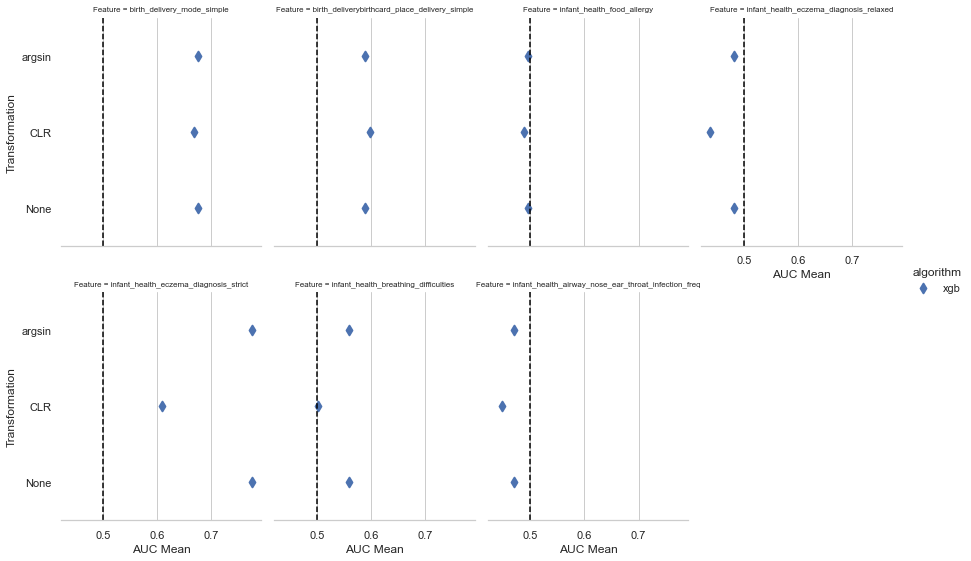

In [66]:
Plot(DF_AUC_mothers)